In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from bs4 import BeautifulSoup as bs
import re
import requests
from unicodedata import normalize
import torch
import torch.nn as nn

# %matplotlib inline # VSCode vs Jupyter Notebook
plt.style.use(['dark_background'])

## Scraping one movie

In [8]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/Escape_Room_(film)', encoding='utf-8')
#dfs = pd.read_html('https://en.wikipedia.org/wiki/Godzilla:_King_of_the_Monsters_(2019_film)', encoding='utf-8')
df = dfs[0]
df

,Escape Room,Escape Room.1
0,Theatrical release poster,Theatrical release poster
1,Directed by,Adam Robitel
2,Produced by,Neal H. Moritz Ori Marmur
3,Screenplay by,Bragi F. Schut Maria Melnik
4,Story by,Bragi Schut
5,Starring,Taylor Russell Logan Miller Deborah Ann Woll J...
6,Music by,Brian TylerJohn Carey
7,Cinematography,Marc Spicer
8,Edited by,Steven Mirkovich
9,Productioncompany,Columbia PicturesOriginal Film


## Getting rid of special characters (e.g. '\xa0')

In [9]:
def clean_normalize_whitespace(x):
    if isinstance(x, str):
        return normalize('NFKC', x).strip()
    else:
        return x

df = df.applymap(clean_normalize_whitespace)

### Replacement and setting header

In [10]:
df.iloc[:, 1].replace(r'(\[\w\])', '', regex=True, inplace=True)
df.iloc[:, 1].replace(r'\$', '', regex=True, inplace=True)
header = df.T.iloc[0]
df = df.T.iloc[1:]
df.columns = header 

df.index = df.index.str.replace(r'\.1', '', regex=True)
df = df.reset_index().rename(columns={'index':'title'})
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df.drop('theatrical_release_poster', axis=1, errors='ignore')
df.drop(list(df.filter(regex='poster')), axis=1, inplace=True, errors='ignore')
df.columns.name = None

df.head()

,title,directed_by,produced_by,screenplay_by,story_by,starring,music_by,cinematography,edited_by,productioncompany,distributed_by,release_date,running_time,country,language,budget,box_office
0,Escape Room,Adam Robitel,Neal H. Moritz Ori Marmur,Bragi F. Schut Maria Melnik,Bragi Schut,Taylor Russell Logan Miller Deborah Ann Woll J...,Brian TylerJohn Carey,Marc Spicer,Steven Mirkovich,Columbia PicturesOriginal Film,Sony Pictures Releasing,"January 4, 2019",100 minutes,United States,English,9 million,155.7 million


### Mapping words to numbers

In [11]:
repl_dict = {'(T|t)housand': '*1e3', '(M|m)illion': '*1e6', '(B|b)illion': '*1e9'}
df['box_office'] = df['box_office'].replace(repl_dict, regex=True).replace(r' ', '', regex=True).map(pd.eval)

### Minimalist testing function

In [13]:
def clean_minimal(df):
    df = df.applymap(clean_normalize_whitespace)
    df.iloc[:, 1].replace(r'(\[\w\])', '', regex=True, inplace=True)
    df.iloc[:, 1].replace(r'\$', '', regex=True, inplace=True)
    header = df.T.iloc[0]
    df = df.T.iloc[1:]
    df.columns = header    

    df.index = df.index.str.replace(r'\.1', '', regex=True)
    df = df.reset_index().rename(columns={'index':'title'})
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df = df.drop('theatrical_release_poster', axis=1, errors='ignore')
    df.drop(list(df.filter(regex='poster')), axis=1, inplace=True, errors='ignore')
    df.columns.name = None

    return df

## Scraping Data from all Movies

In [14]:
url = 'https://en.wikipedia.org/wiki/List_of_American_films_of_2019'
r = requests.get(url)
soup = bs(r.text, 'html.parser')

def get_table(url):
    r = requests.get(url)
    soup = bs(r.content, 'html.parser')
    
    dfs = pd.read_html(url)
    df = clean_minimal(dfs[0])

    return df

get_table('https://en.wikipedia.org/wiki/Escape_Room_(film)')

,title,directed_by,produced_by,screenplay_by,story_by,starring,music_by,cinematography,edited_by,productioncompany,distributed_by,release_date,running_time,country,language,budget,box_office
0,Escape Room,Adam Robitel,Neal H. Moritz Ori Marmur,Bragi F. Schut Maria Melnik,Bragi Schut,Taylor Russell Logan Miller Deborah Ann Woll J...,Brian TylerJohn Carey,Marc Spicer,Steven Mirkovich,Columbia PicturesOriginal Film,Sony Pictures Releasing,"January 4, 2019",100 minutes,United States,English,9 million,155.7 million


In [ ]:
hrefs = soup.select('tr td i a')
links = [href['href'] for href in hrefs]
base_path = 'https://en.wikipedia.org/'

link_test = links[:3]

movie_data_list = []
for idx, link in enumerate(links):
    if (idx+1) % 10 == 0:
        print(idx+1)
    try:
        full_path = base_path + link        
        movie_data_list.append(get_table(full_path))
        
    except Exception as e:
        print(str(e))

In [ ]:
big_df = pd.concat(movie_data_list)
# Remove last 3 irrelevant columns
big_df = big_df.drop(big_df.columns[-3:], axis=1)
# Save to csv
big_df.to_csv('240-minus3.csv', index=False, header=big_df.columns.values)

### Read back in the saved csv

In [5]:
df = pd.read_csv('240-minus3.csv')
df.head()

,title,directed_by,produced_by,screenplay_by,based_on,starring,music_by,cinematography,edited_by,productioncompany,...,release_date,running_time,country,language,budget,box_office,story_by,productioncompanies,written_by,narrated_by
0,Avengers: Endgame,Anthony RussoJoe Russo,Kevin Feige,Christopher MarkusStephen McFeely,The Avengersby Stan LeeJack Kirby,Robert Downey Jr. Chris Evans Mark Ruffalo Chr...,Alan Silvestri,Trent Opaloch,Jeffrey Ford Matthew Schmidt,Marvel Studios,...,"April 22, 2019Los Angeles Convention Center) A...",181 minutes,United States,English,356 million,2.798 billion,NaN,NaN,NaN,NaN
1,The Lion King,Jon Favreau,Jon Favreau Jeffrey Silver Karen Gilchrist,Jeff Nathanson,Disney's The Lion Kingby Irene MecchiJonathan ...,Donald Glover Seth Rogen Chiwetel Ejiofor Alfr...,Hans Zimmer,Caleb Deschanel,Mark Livolsi Adam Gerstel,Walt Disney Pictures Fairview Entertainment,...,"July 9, 2019Hollywood) July 19, 2019",118 minutes,United States,English,250–260 million,1.657 billion,NaN,NaN,NaN,NaN
2,Star Wars: The Rise of Skywalker,J. J. Abrams,Kathleen Kennedy J. J. Abrams Michelle Rejwan,Chris Terrio J. J. Abrams,Charactersby George Lucas,Carrie Fisher Mark Hamill Adam Driver Daisy Ri...,John Williams,Dan Mindel,Maryann Brandon Stefan Grube,Lucasfilm Ltd. Bad Robot Productions,...,"December 16, 2019Hollywood) December 20, 2019",142 minutes,United States,English,275 million,1.074 billion,Derek Connolly Colin Trevorrow J. J. Abrams Ch...,NaN,NaN,NaN
3,Frozen II,Chris Buck Jennifer Lee,Peter Del Vecho,Jennifer Lee,NaN,Kristen Bell Idina Menzel Josh Gad Jonathan Groff,Christophe Beck (score) Robert Lopez (songs) K...,Tracy Scott Beattie (layout) Mohit Kallianpur ...,Jeff Draheim,Walt Disney Pictures Walt Disney Animation Stu...,...,"November 7, 2019Dolby Theatre) November 22, 2019",103 minutes,United States,English,150 million,1.450 billion,Chris Buck Jennifer Lee Marc E. Smith Kristen ...,NaN,NaN,NaN
4,Toy Story 4,Josh Cooley,Mark Nielsen Jonas Rivera,Andrew Stanton Stephany Folsom,NaN,Tom Hanks Tim Allen Annie Potts Tony Hale Keeg...,Randy Newman,Patrick Lin Jean-Claude Kalache,Axel Geddes,NaN,...,"June 11, 2019El Capitan Theatre) June 21, 2019",100 minutes,United States,English,200 million,1.073 billion,John Lasseter Andrew Stanton Josh Cooley Valer...,Walt Disney Pictures Pixar Animation Studios,NaN,NaN


### Function to clean whole datafrme

In [6]:
repl_dict = {'(T|t)housand': '*1e3', '(M|m)illion': '*1e6', '(B|b)illion': '*1e9'}

def clean_table(df):
    # Release date
    df['release_date'] = [item.split(')')[-1].strip() for item in df['release_date']]
    df.loc[df['release_date'].str.len() > 19, 'release_date'] = [re.split('\d{4}', item, 1)[-1] for item in df['release_date'] if len(item) > 19]
    df.loc[df['release_date'].str.len() > 19, 'release_date'] = [re.split('\d{4}', item, 1)[-1] for item in df['release_date'] if len(item) > 19]
    df['release_date'] = pd.to_datetime(df['release_date'])

    # Running time
    df = df[df['running_time'].notna()]
    df['running_time'] = [pd.to_numeric(item.split(' ')[0]) for item in df['running_time']]

    # Budget
    df = df[df['budget'].notna()]
    df['budget'].replace(r'€', '', regex=True, inplace=True)
    df['budget'] = [item.split('–')[-1] for item in df['budget']]
    df['budget'] = [item.split('-')[-1] for item in df['budget']]
    df['budget'].replace(r'000', 'thousand', regex=True, inplace=True)
    df['budget'] = df['budget'].replace(r'\([^)]*\)', '', regex=True)
    df['budget'] = df['budget'].replace(r'\[[^\]]*\]', '', regex=True)
    df['budget'] = df['budget'].replace(r'more than', '', regex=True)
    df['budget'] = [item.replace(',', ' ') for item in df['budget']]
    df['budget'] = df['budget'].replace(repl_dict, regex=True).replace(r' ', '', regex=True).map(pd.eval)

    # Box Office
    df = df[df['box_office'].notna()]
    df['box_office'] = [item.split('–')[-1] for item in df['box_office']]
    df['box_office'] = [item.split('-')[-1] for item in df['box_office']]
    df['box_office'] = df['box_office'].replace(r'\([^)]*\)', '', regex=True)
    df['box_office'] = df['box_office'].replace(r'\[[^\]]*\]', '', regex=True)
    df['box_office'] = df['box_office'].replace(r'at least', '', regex=True)
    df['box_office'] = [item.replace('+', '') for item in df['box_office']]
    df['box_office'] = [item.replace(',', '') for item in df['box_office']]
    df['box_office'] = df['box_office'].replace(repl_dict, regex=True).replace(r' ', '', regex=True).map(pd.eval)

    return df

df = clean_table(df)
df.head()

,title,directed_by,produced_by,screenplay_by,based_on,starring,music_by,cinematography,edited_by,productioncompany,...,release_date,running_time,country,language,budget,box_office,story_by,productioncompanies,written_by,narrated_by
0,Avengers: Endgame,Anthony RussoJoe Russo,Kevin Feige,Christopher MarkusStephen McFeely,The Avengersby Stan LeeJack Kirby,Robert Downey Jr. Chris Evans Mark Ruffalo Chr...,Alan Silvestri,Trent Opaloch,Jeffrey Ford Matthew Schmidt,Marvel Studios,...,2019-04-26,181,United States,English,356000000.0,2.798000e+09,NaN,NaN,NaN,NaN
1,The Lion King,Jon Favreau,Jon Favreau Jeffrey Silver Karen Gilchrist,Jeff Nathanson,Disney's The Lion Kingby Irene MecchiJonathan ...,Donald Glover Seth Rogen Chiwetel Ejiofor Alfr...,Hans Zimmer,Caleb Deschanel,Mark Livolsi Adam Gerstel,Walt Disney Pictures Fairview Entertainment,...,2019-07-19,118,United States,English,260000000.0,1.657000e+09,NaN,NaN,NaN,NaN
2,Star Wars: The Rise of Skywalker,J. J. Abrams,Kathleen Kennedy J. J. Abrams Michelle Rejwan,Chris Terrio J. J. Abrams,Charactersby George Lucas,Carrie Fisher Mark Hamill Adam Driver Daisy Ri...,John Williams,Dan Mindel,Maryann Brandon Stefan Grube,Lucasfilm Ltd. Bad Robot Productions,...,2019-12-20,142,United States,English,275000000.0,1.074000e+09,Derek Connolly Colin Trevorrow J. J. Abrams Ch...,NaN,NaN,NaN
3,Frozen II,Chris Buck Jennifer Lee,Peter Del Vecho,Jennifer Lee,NaN,Kristen Bell Idina Menzel Josh Gad Jonathan Groff,Christophe Beck (score) Robert Lopez (songs) K...,Tracy Scott Beattie (layout) Mohit Kallianpur ...,Jeff Draheim,Walt Disney Pictures Walt Disney Animation Stu...,...,2019-11-22,103,United States,English,150000000.0,1.450000e+09,Chris Buck Jennifer Lee Marc E. Smith Kristen ...,NaN,NaN,NaN
4,Toy Story 4,Josh Cooley,Mark Nielsen Jonas Rivera,Andrew Stanton Stephany Folsom,NaN,Tom Hanks Tim Allen Annie Potts Tony Hale Keeg...,Randy Newman,Patrick Lin Jean-Claude Kalache,Axel Geddes,NaN,...,2019-06-21,100,United States,English,200000000.0,1.073000e+09,John Lasseter Andrew Stanton Josh Cooley Valer...,Walt Disney Pictures Pixar Animation Studios,NaN,NaN


### Attempt to clean up `country`

In [7]:
# df = pd.read_csv('240-minus3.csv')
df['country'] = df['country'].fillna('NA')
# Split based on capital letters
st = [', '.join(re.findall('[a-zA-Z][^A-Z]*', str(item))) for item in df['country']]

us_list = []
uk_list = []
cr_list = []
nz_list = []

for item in st:
    if item.find('United') != -1 and item.find('States') != -1:
        us = ', '.join(item.replace('United', '').replace('States', 'USA').replace(',', '').split())
        us_list.append(us)
    if item.find('United') != -1 and item.find('Kingdom') != -1:
        uk = ', '.join(item.replace('United', '').replace('Kingdom', 'UK').replace(',', '').split())
        uk_list.append(uk)
    if item.find('Czech') != -1 and item.find('Republic') != -1:
        cr = ', '.join(item.replace('Czech', '').replace('Republic', 'Czech-Republic').replace(',', '').split())
        cr_list.append(cr)
    if item.find('New') != -1 and item.find('Zealand') != -1:
        nz = ', '.join(item.replace('New', '').replace('Zealand', 'New-Zealand').replace(',', '').split())
        nz_list.append(nz)

df.loc[df['country'].str.contains('States'), 'country'] = us_list
df.loc[df['country'].str.contains('Kingdom'), 'country'] = uk_list
df.loc[df['country'].str.contains('Czech'), 'country'] = cr_list
df.loc[df['country'].str.contains('Zealand'), 'country'] = nz_list

df['country']

0             USA
1             USA
2             USA
3             USA
4             USA
          ...    
233    UK, States
235           USA
236           USA
237    UK, States
238           USA
Name: country, Length: 157, dtype: object

## Exploratory Data Analysis

In [9]:
# df.to_csv('157-cleaned.csv', index=False, header=df.columns.values)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157 entries, 0 to 238
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                157 non-null    object        
 1   directed_by          157 non-null    object        
 2   produced_by          157 non-null    object        
 3   screenplay_by        85 non-null     object        
 4   based_on             79 non-null     object        
 5   starring             157 non-null    object        
 6   music_by             155 non-null    object        
 7   cinematography       150 non-null    object        
 8   edited_by            156 non-null    object        
 9   productioncompany    102 non-null    object        
 10  distributed_by       157 non-null    object        
 11  release_date         154 non-null    datetime64[ns]
 12  running_time         157 non-null    int64         
 13  country              157 non-null  

### Budget vs Box office

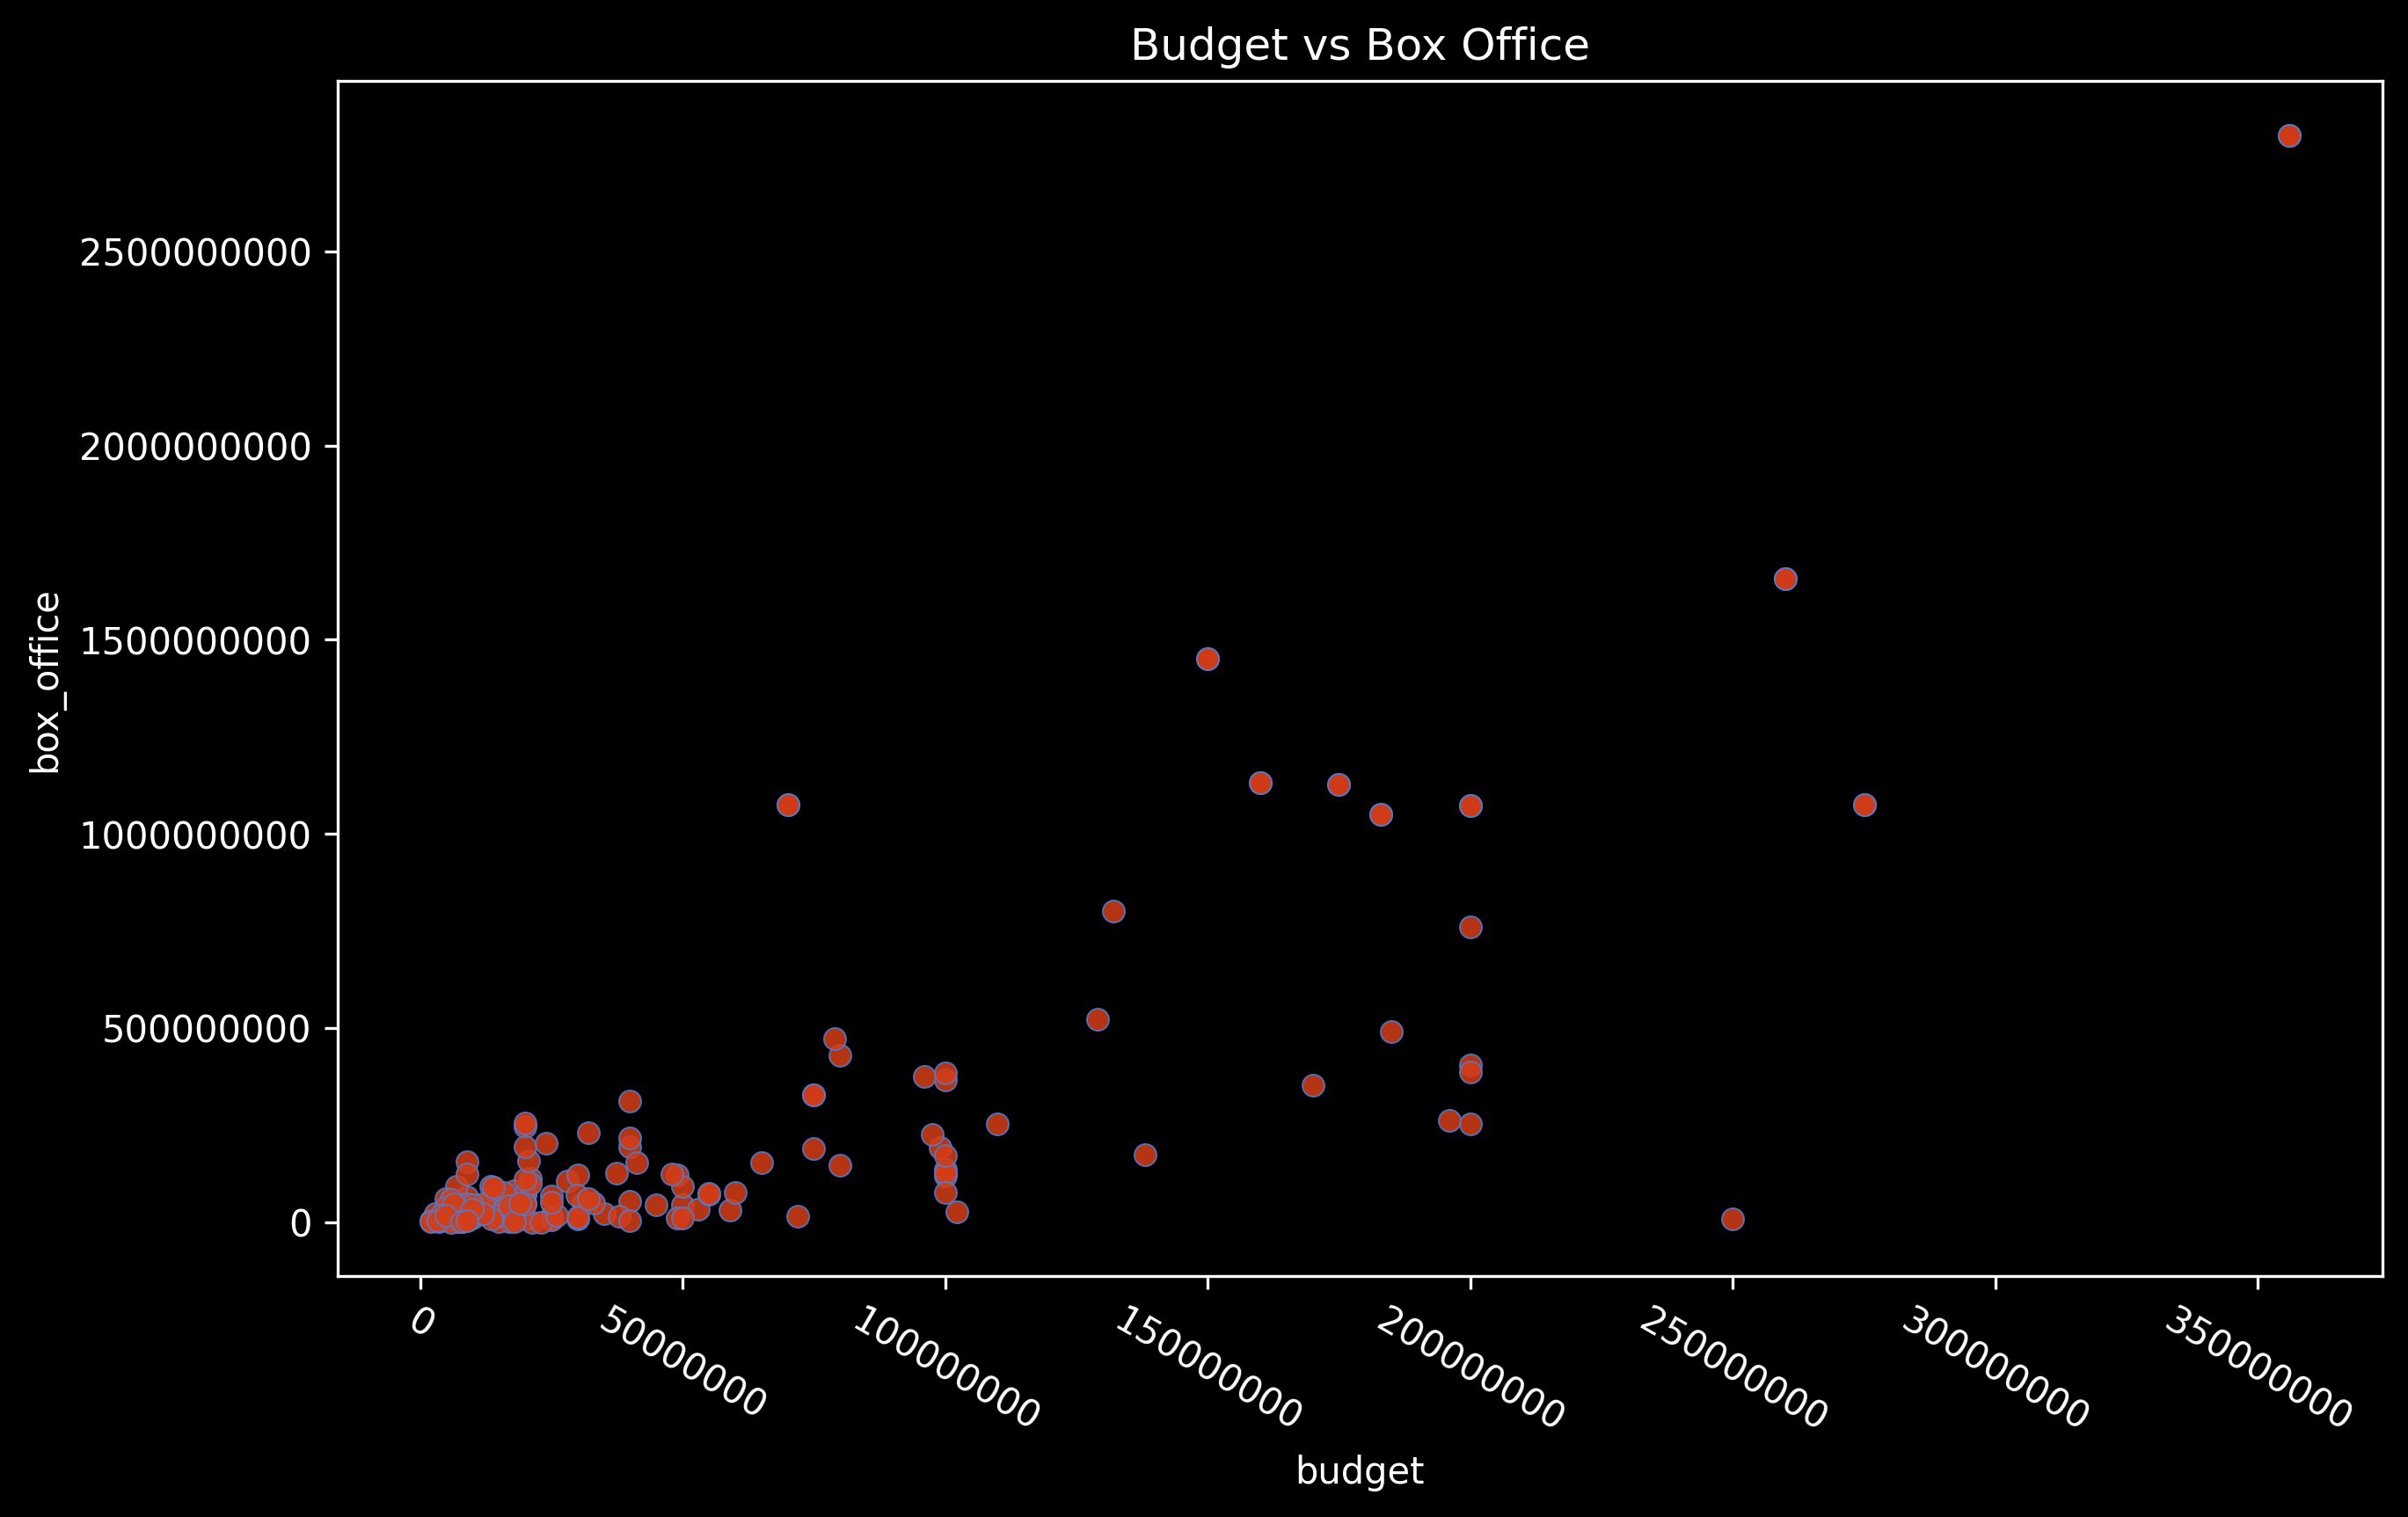

In [73]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='budget', y='box_office', data=df, color='#d43d17', alpha=0.86, edgecolor='#547BCA')
plt.xticks(rotation=-30)
plt.title('Budget vs Box Office');

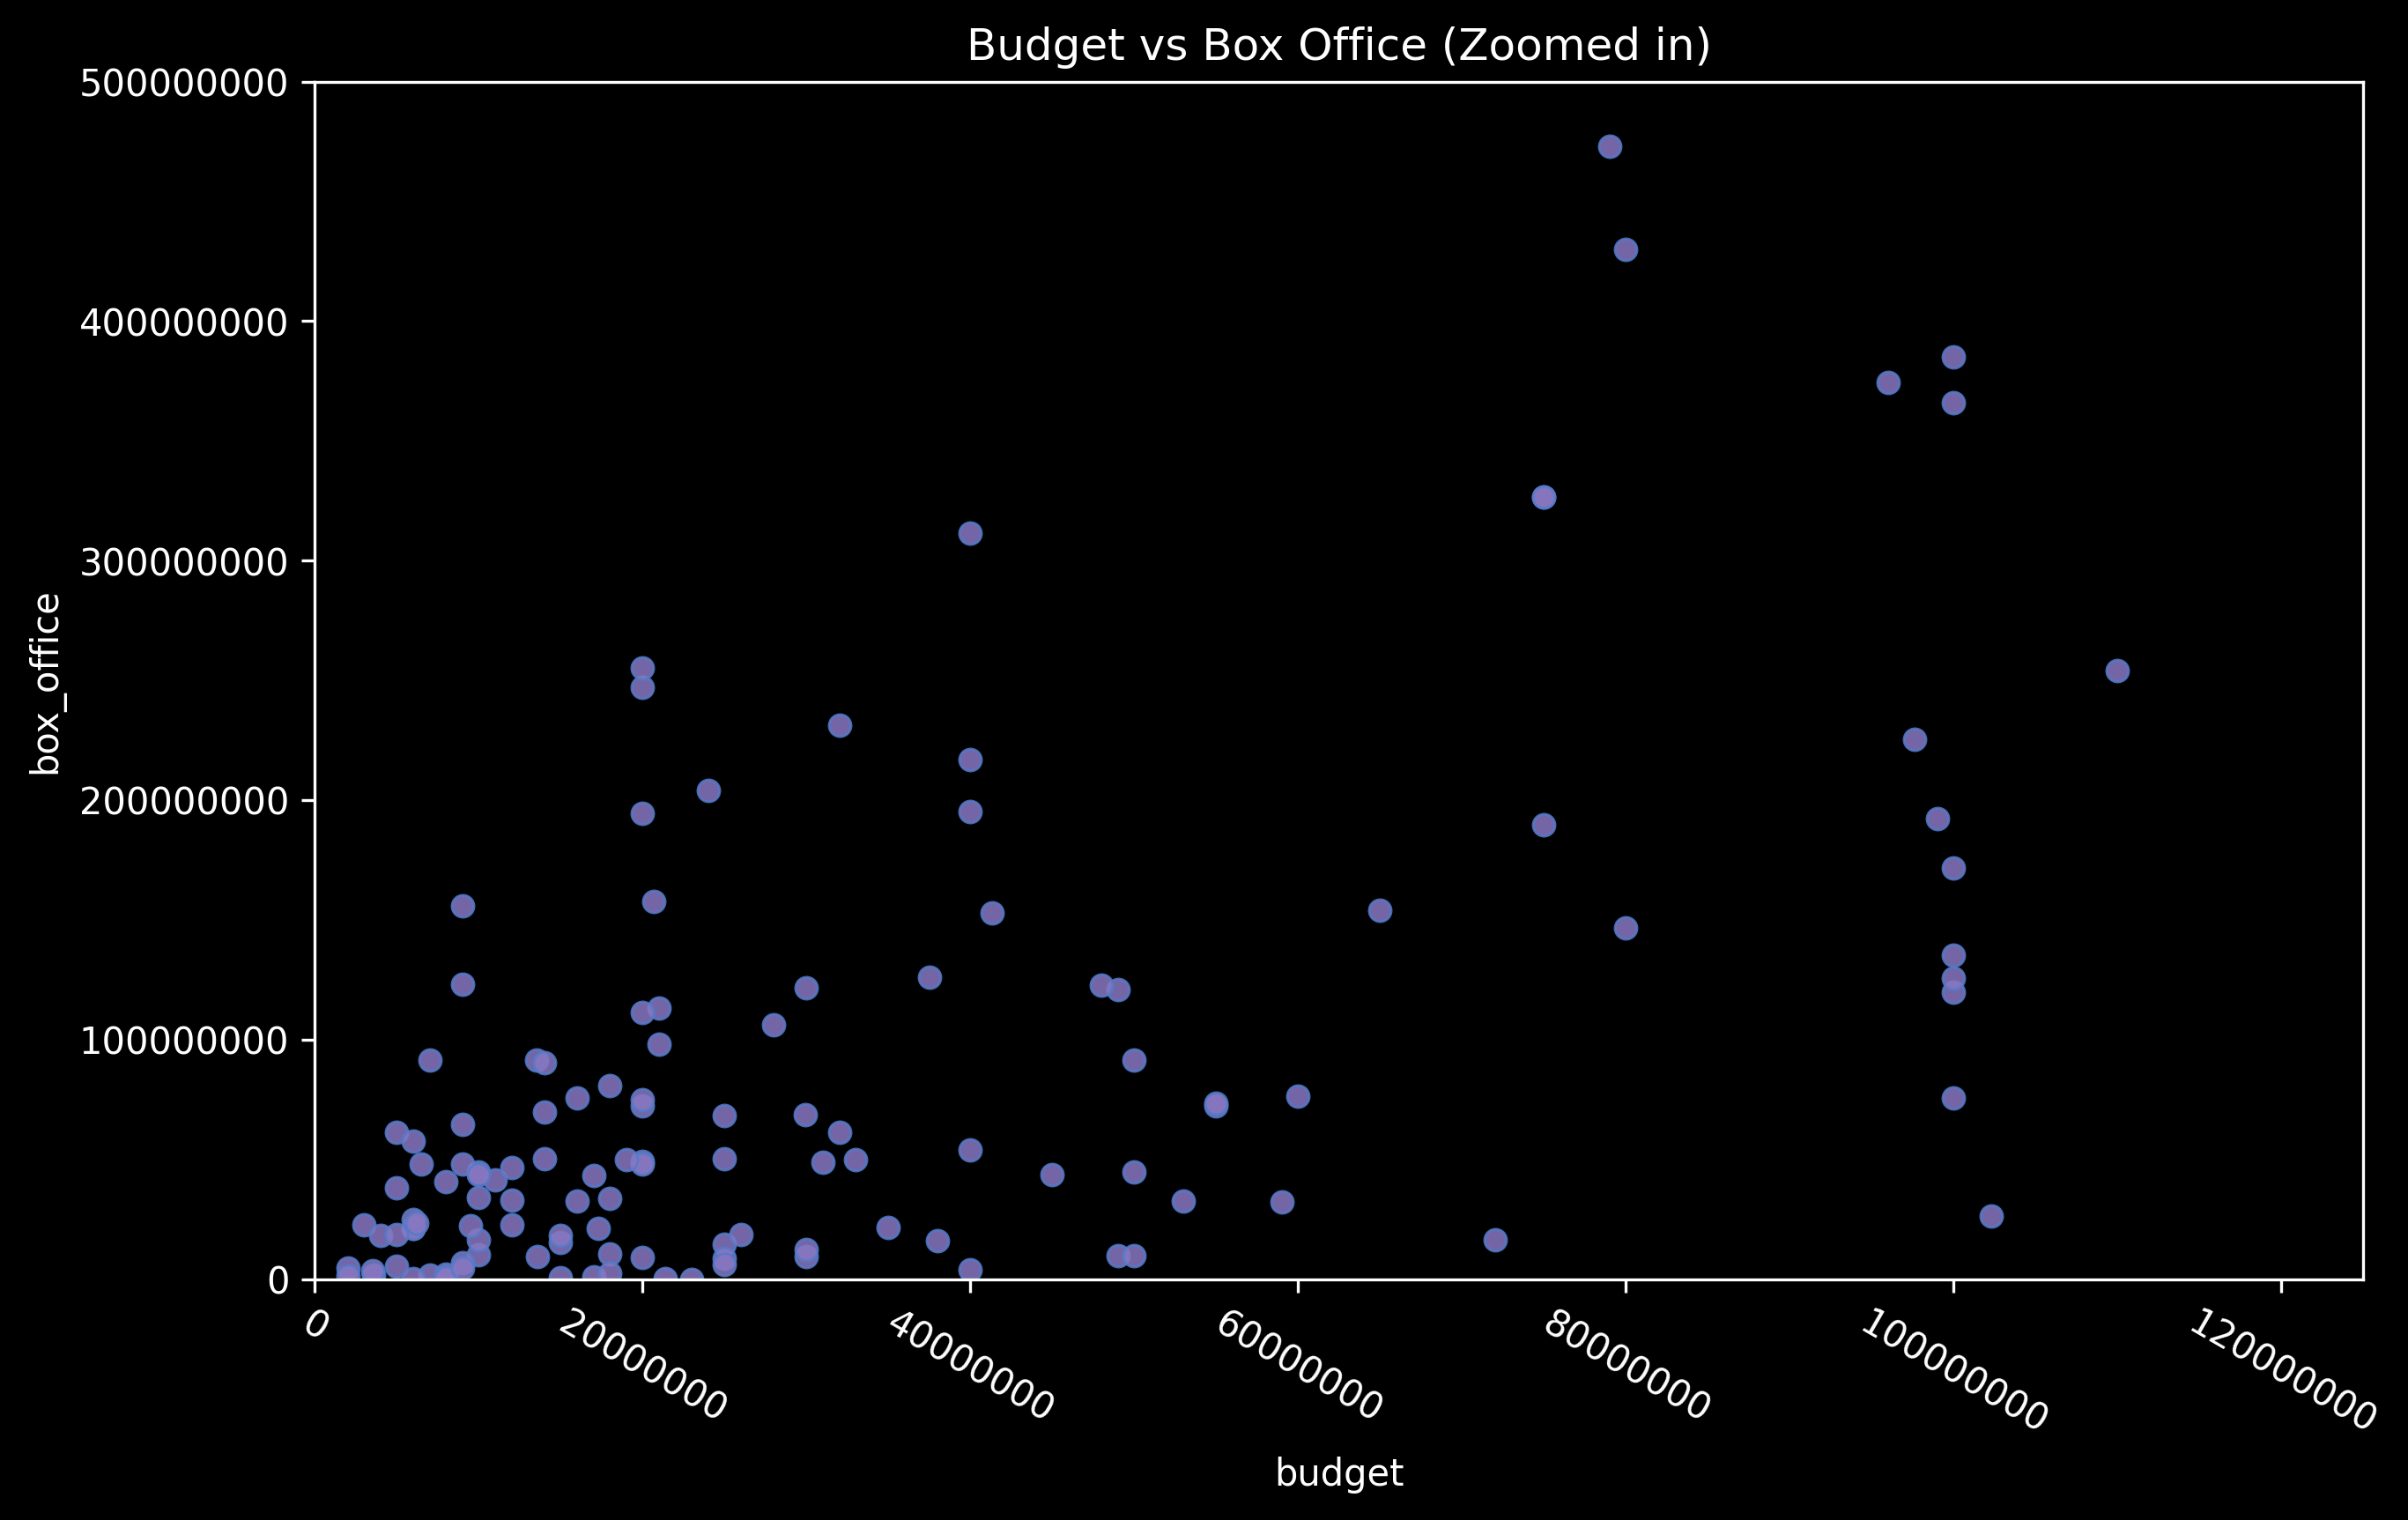

In [78]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='budget', y='box_office', data=df, color='#8878C3', linewidth=0.7, alpha=0.86, edgecolor='#547BCA')
plt.xticks(rotation=-30)
plt.title('Budget vs Box Office (Zoomed in)')
plt.xlim(0, 125000000)
plt.ylim(0, 500000000);

### Running time vs Box office

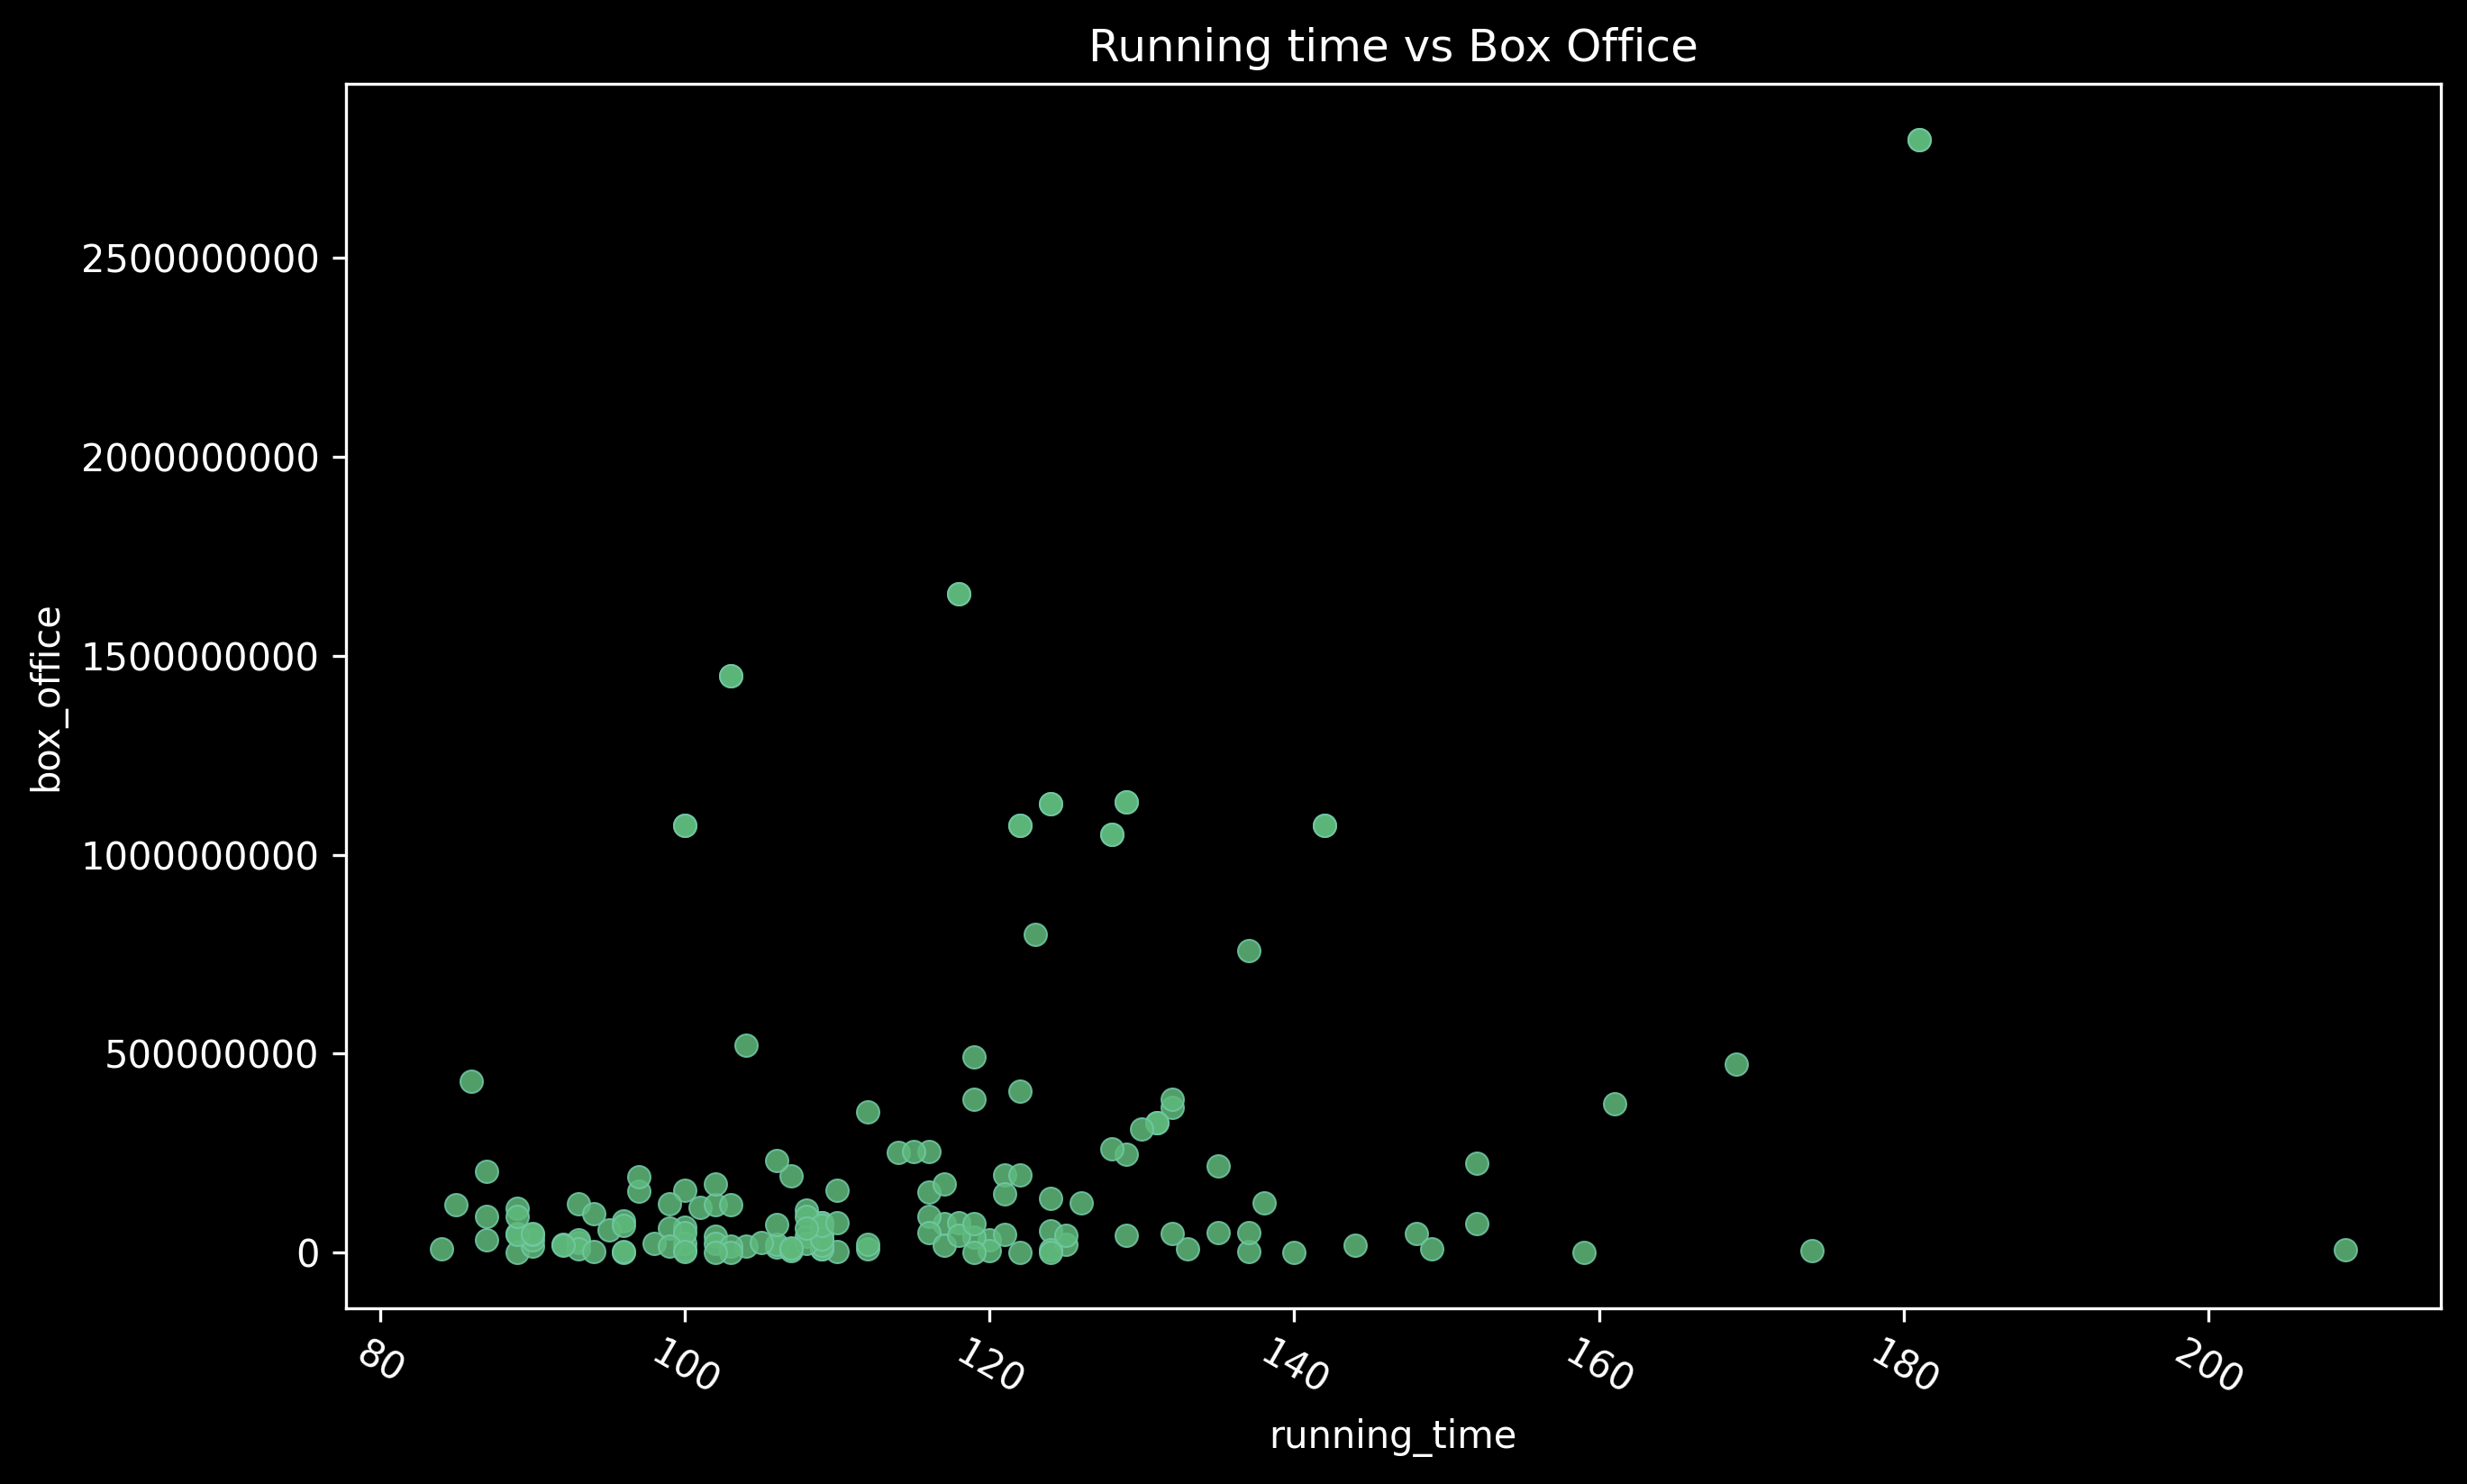

In [76]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='running_time', y='box_office', data=df, color='#5FB97B', alpha=0.86, edgecolor='#72C9A6')
plt.xticks(rotation=-30)
plt.title('Running time vs Box Office');

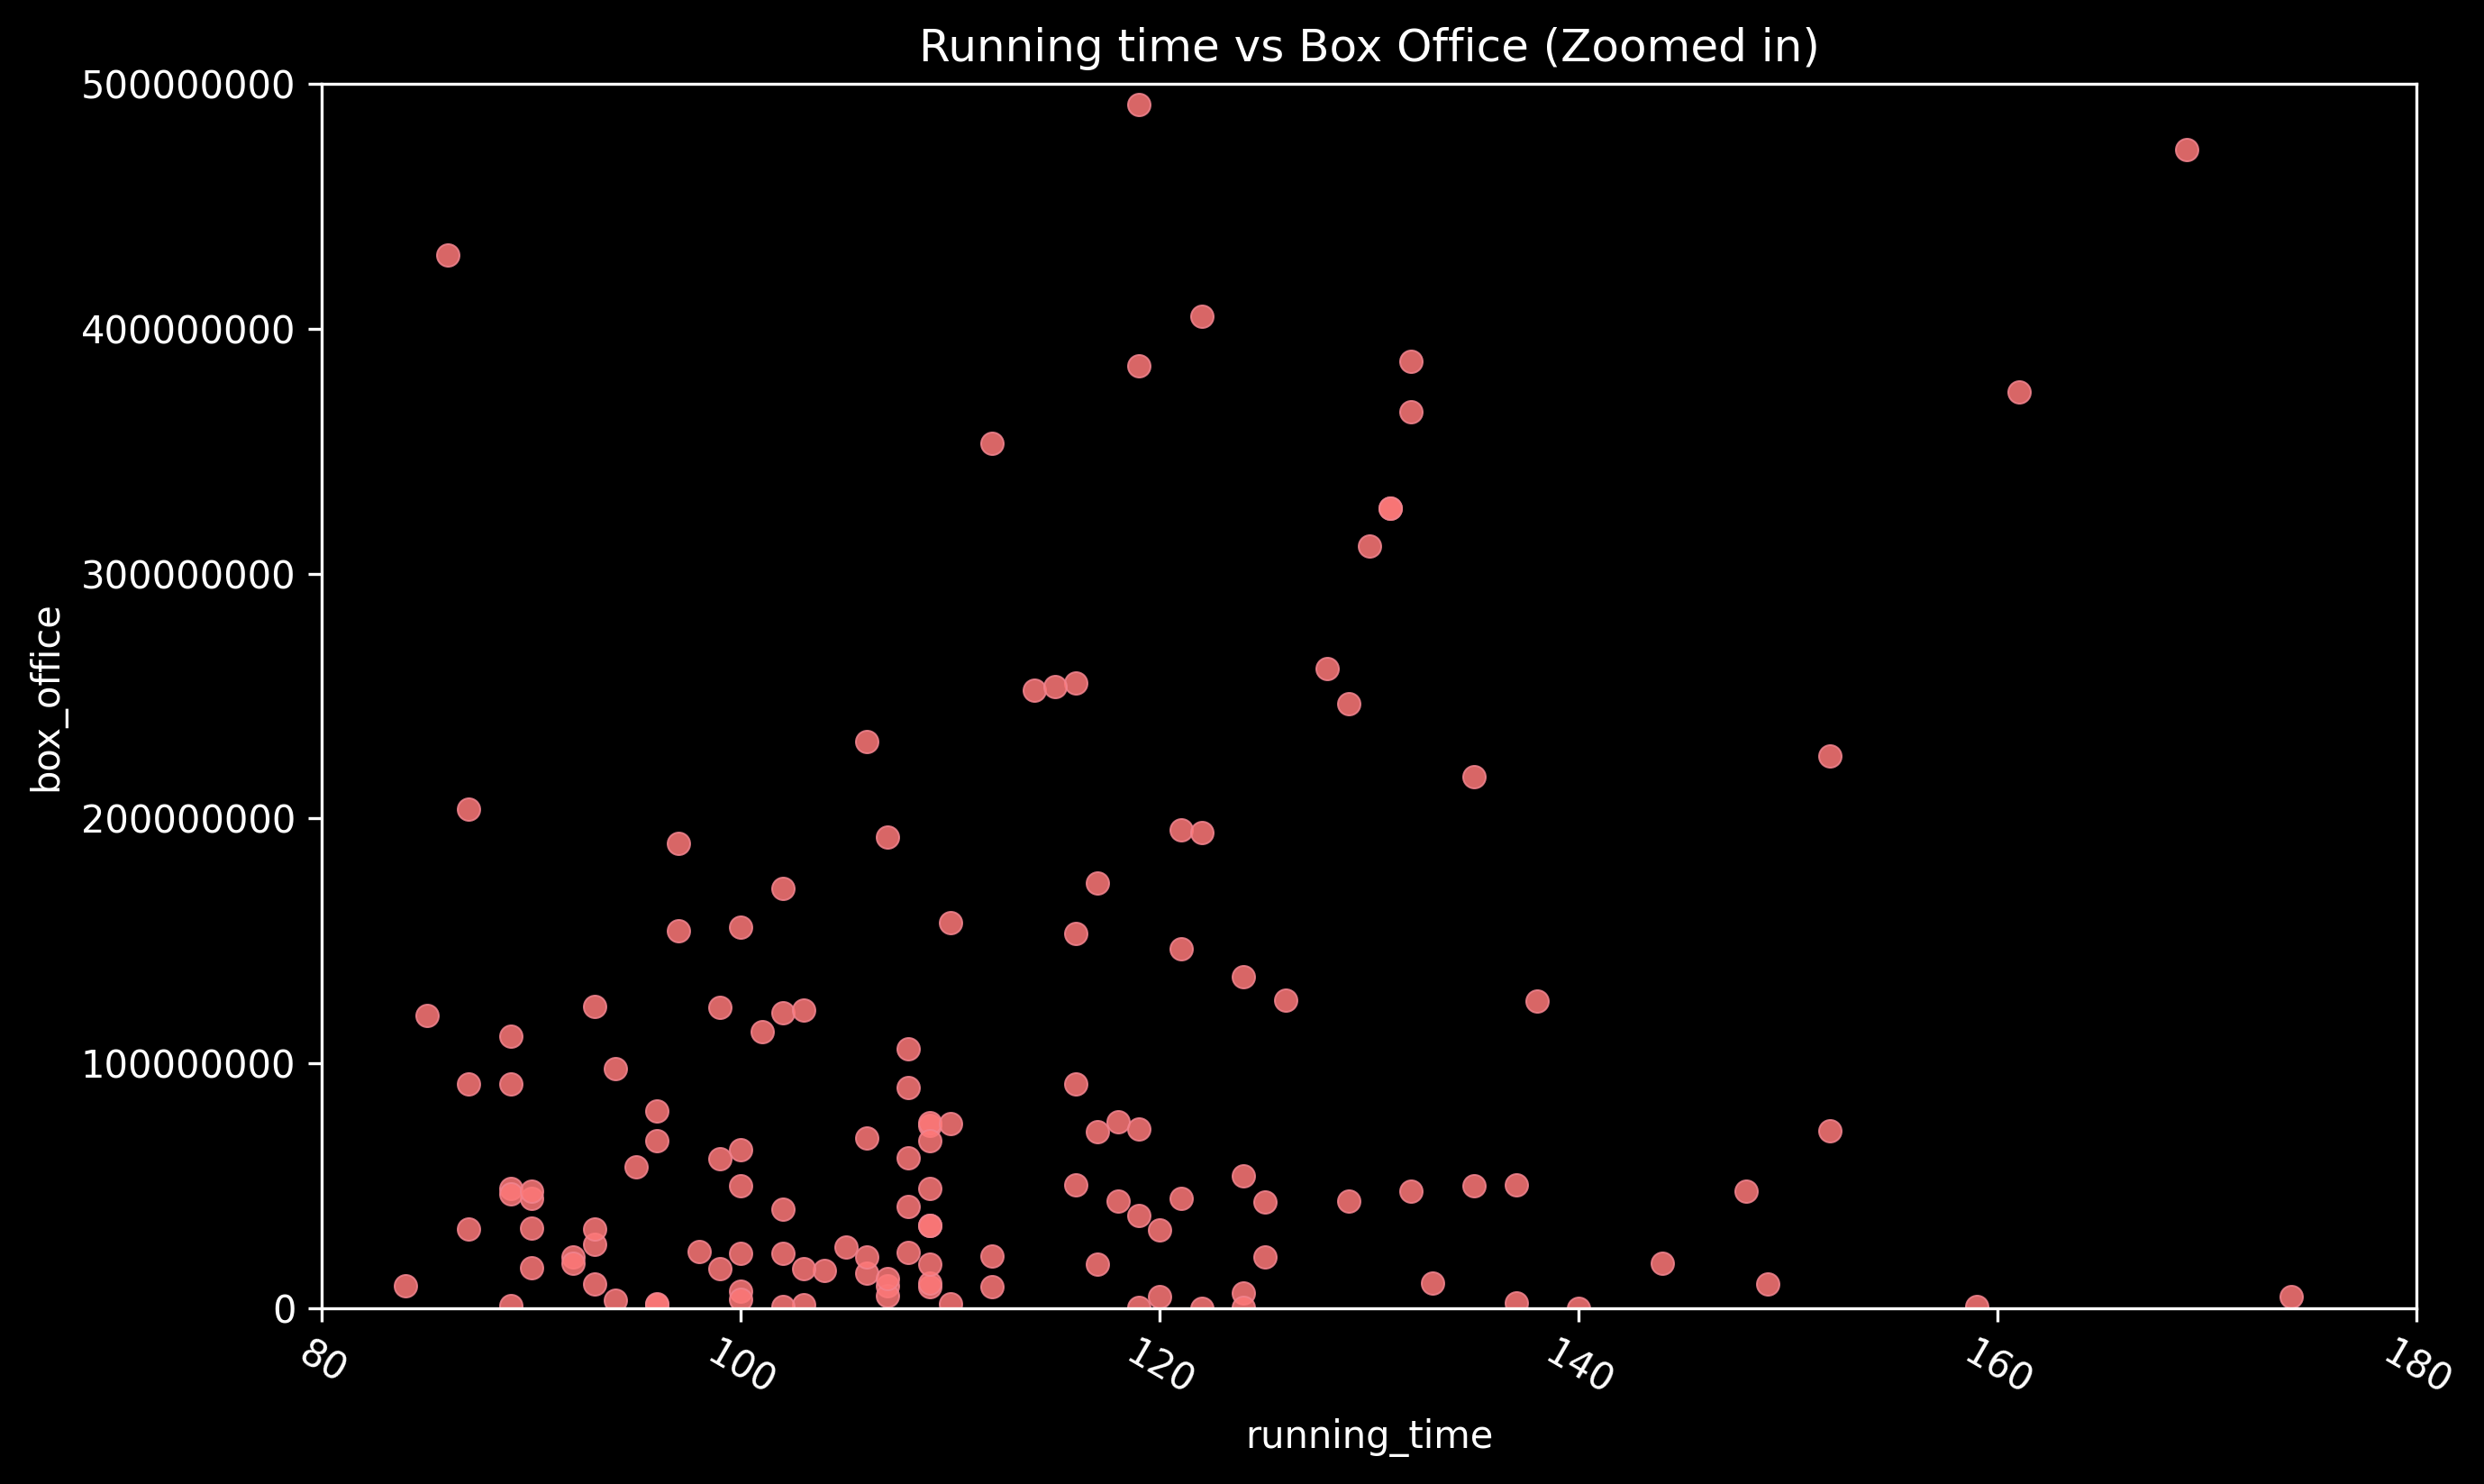

In [81]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='running_time', y='box_office', data=df, color='#FD7878', alpha=0.86, edgecolor='#F2848F')
plt.xticks(rotation=-30)
plt.title('Running time vs Box Office (Zoomed in)')
plt.xlim(80, 180)
plt.ylim(0, 500000000);

## Running time vs Budget

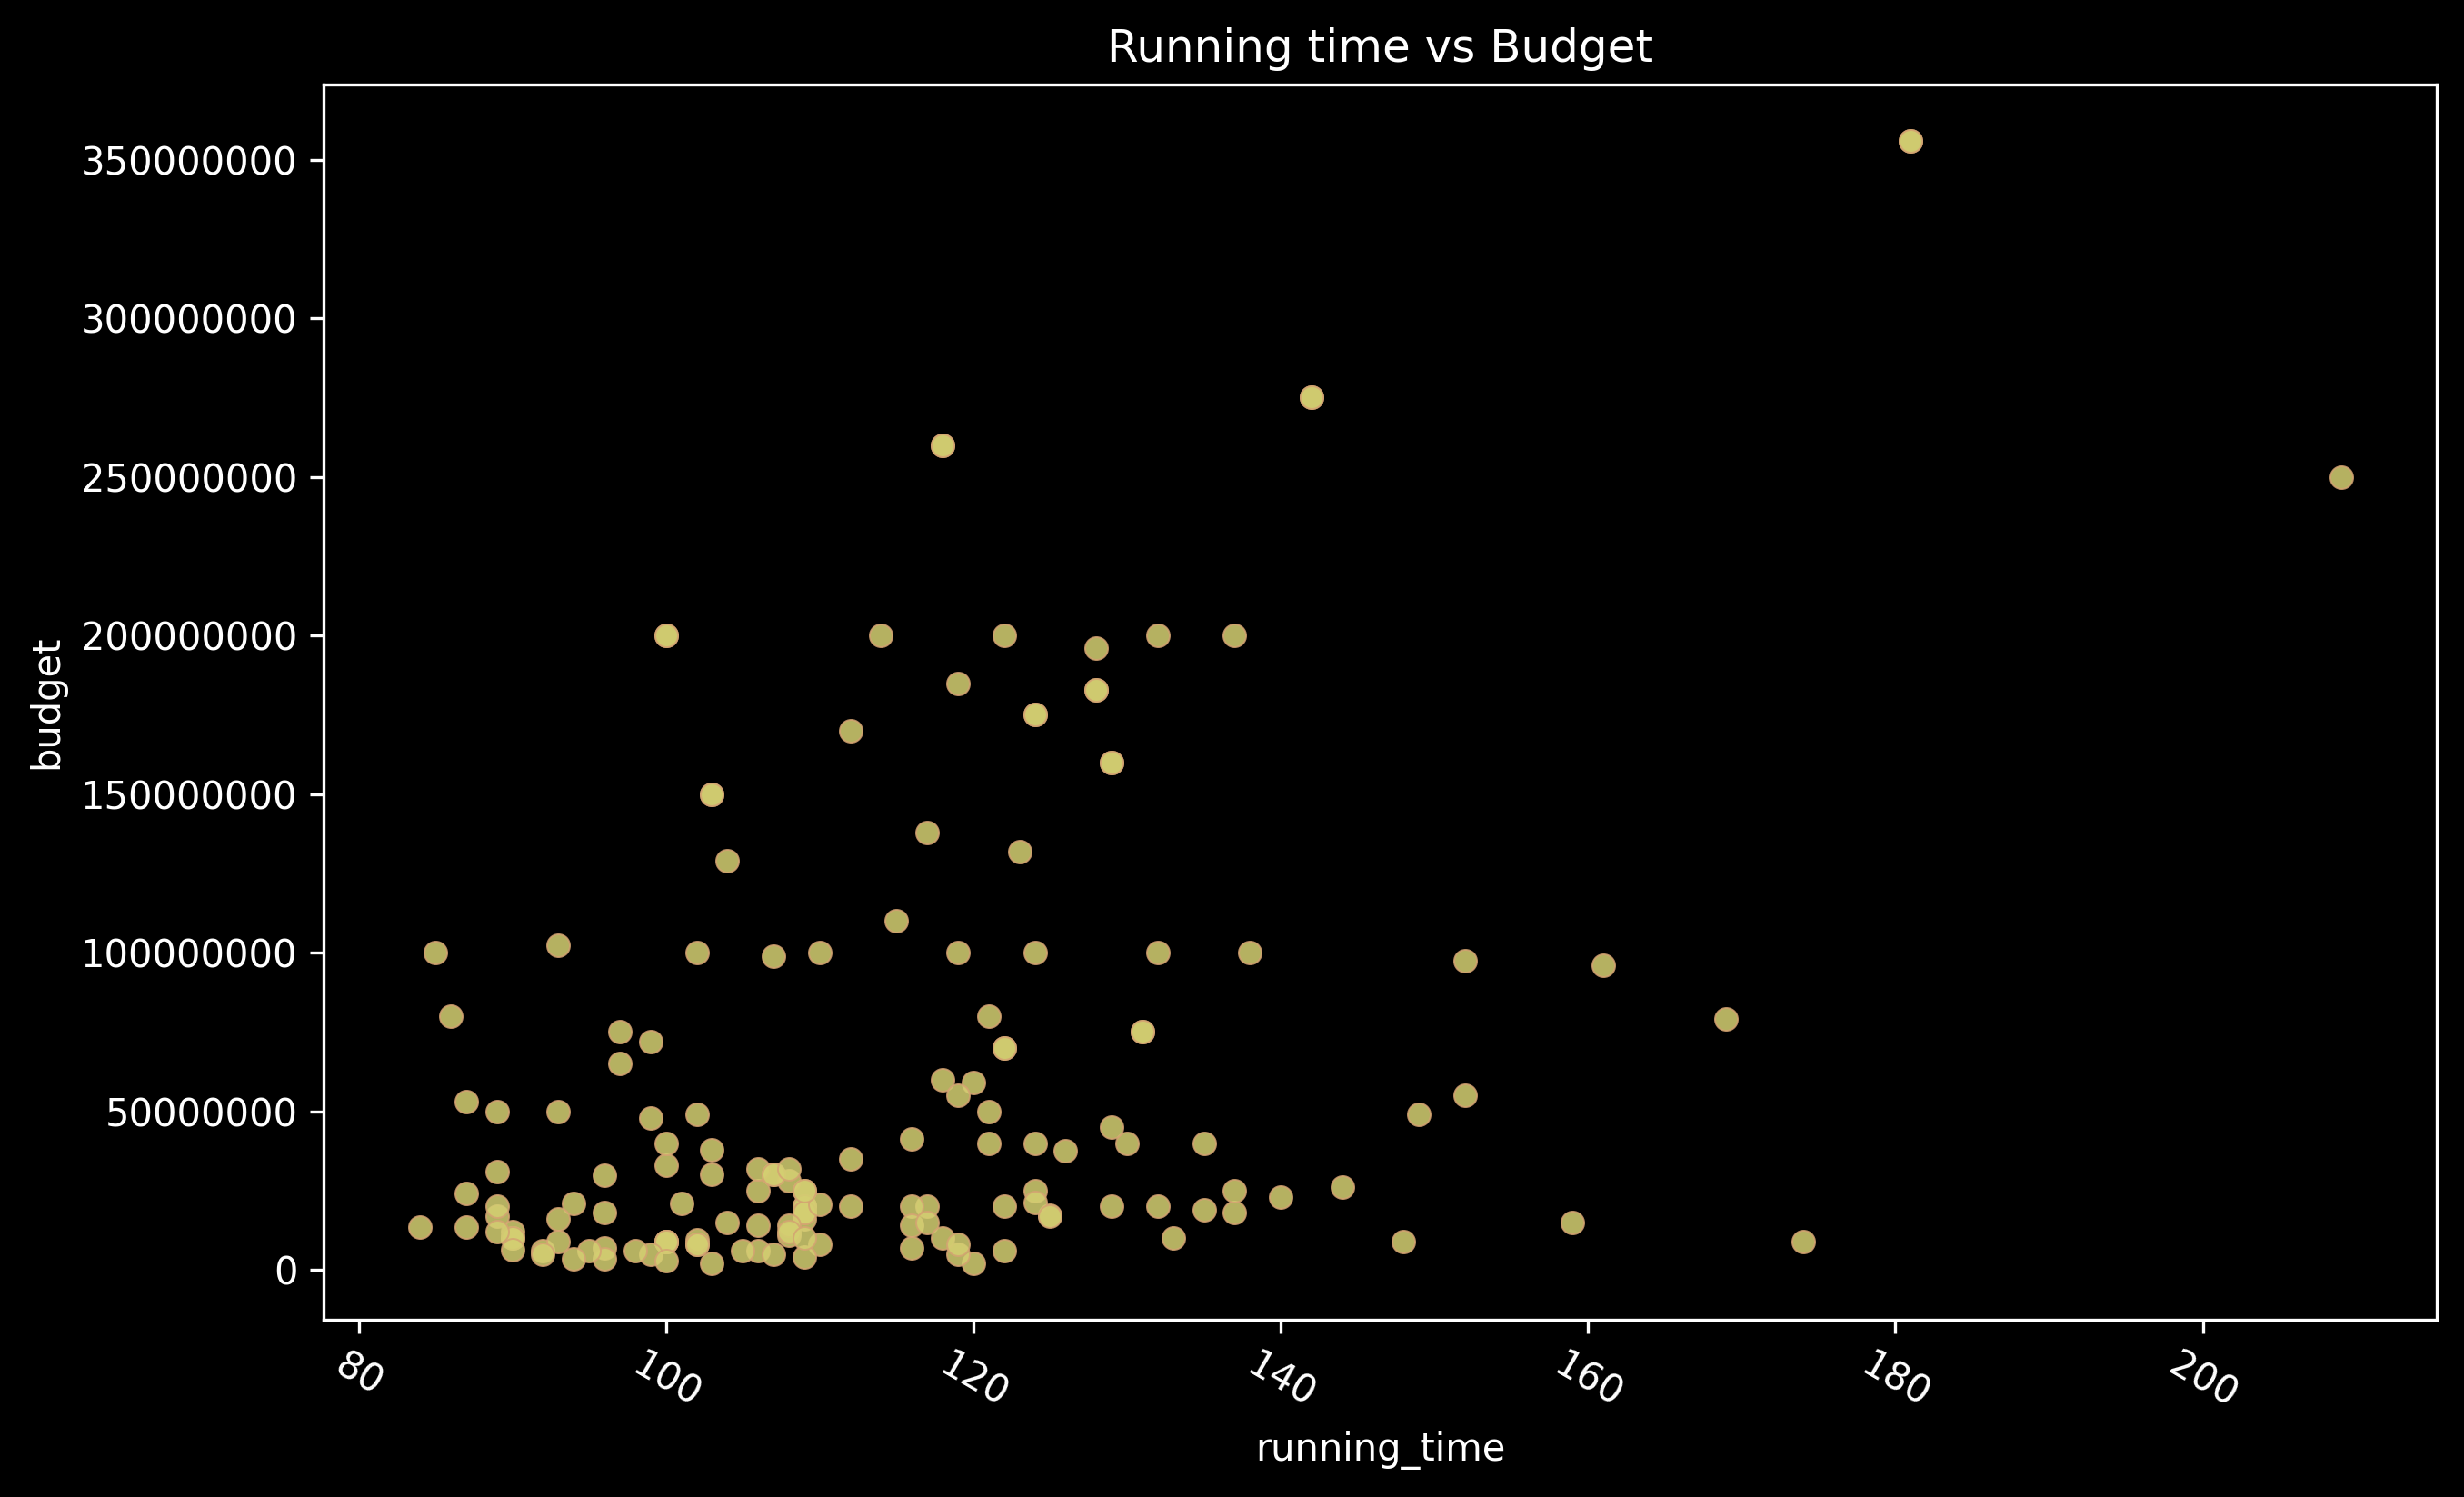

In [85]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='running_time', y='budget', data=df, color='#D4CF72', alpha=0.86, edgecolor='#D4A472')
plt.xticks(rotation=-30)
plt.title('Running time vs Budget');

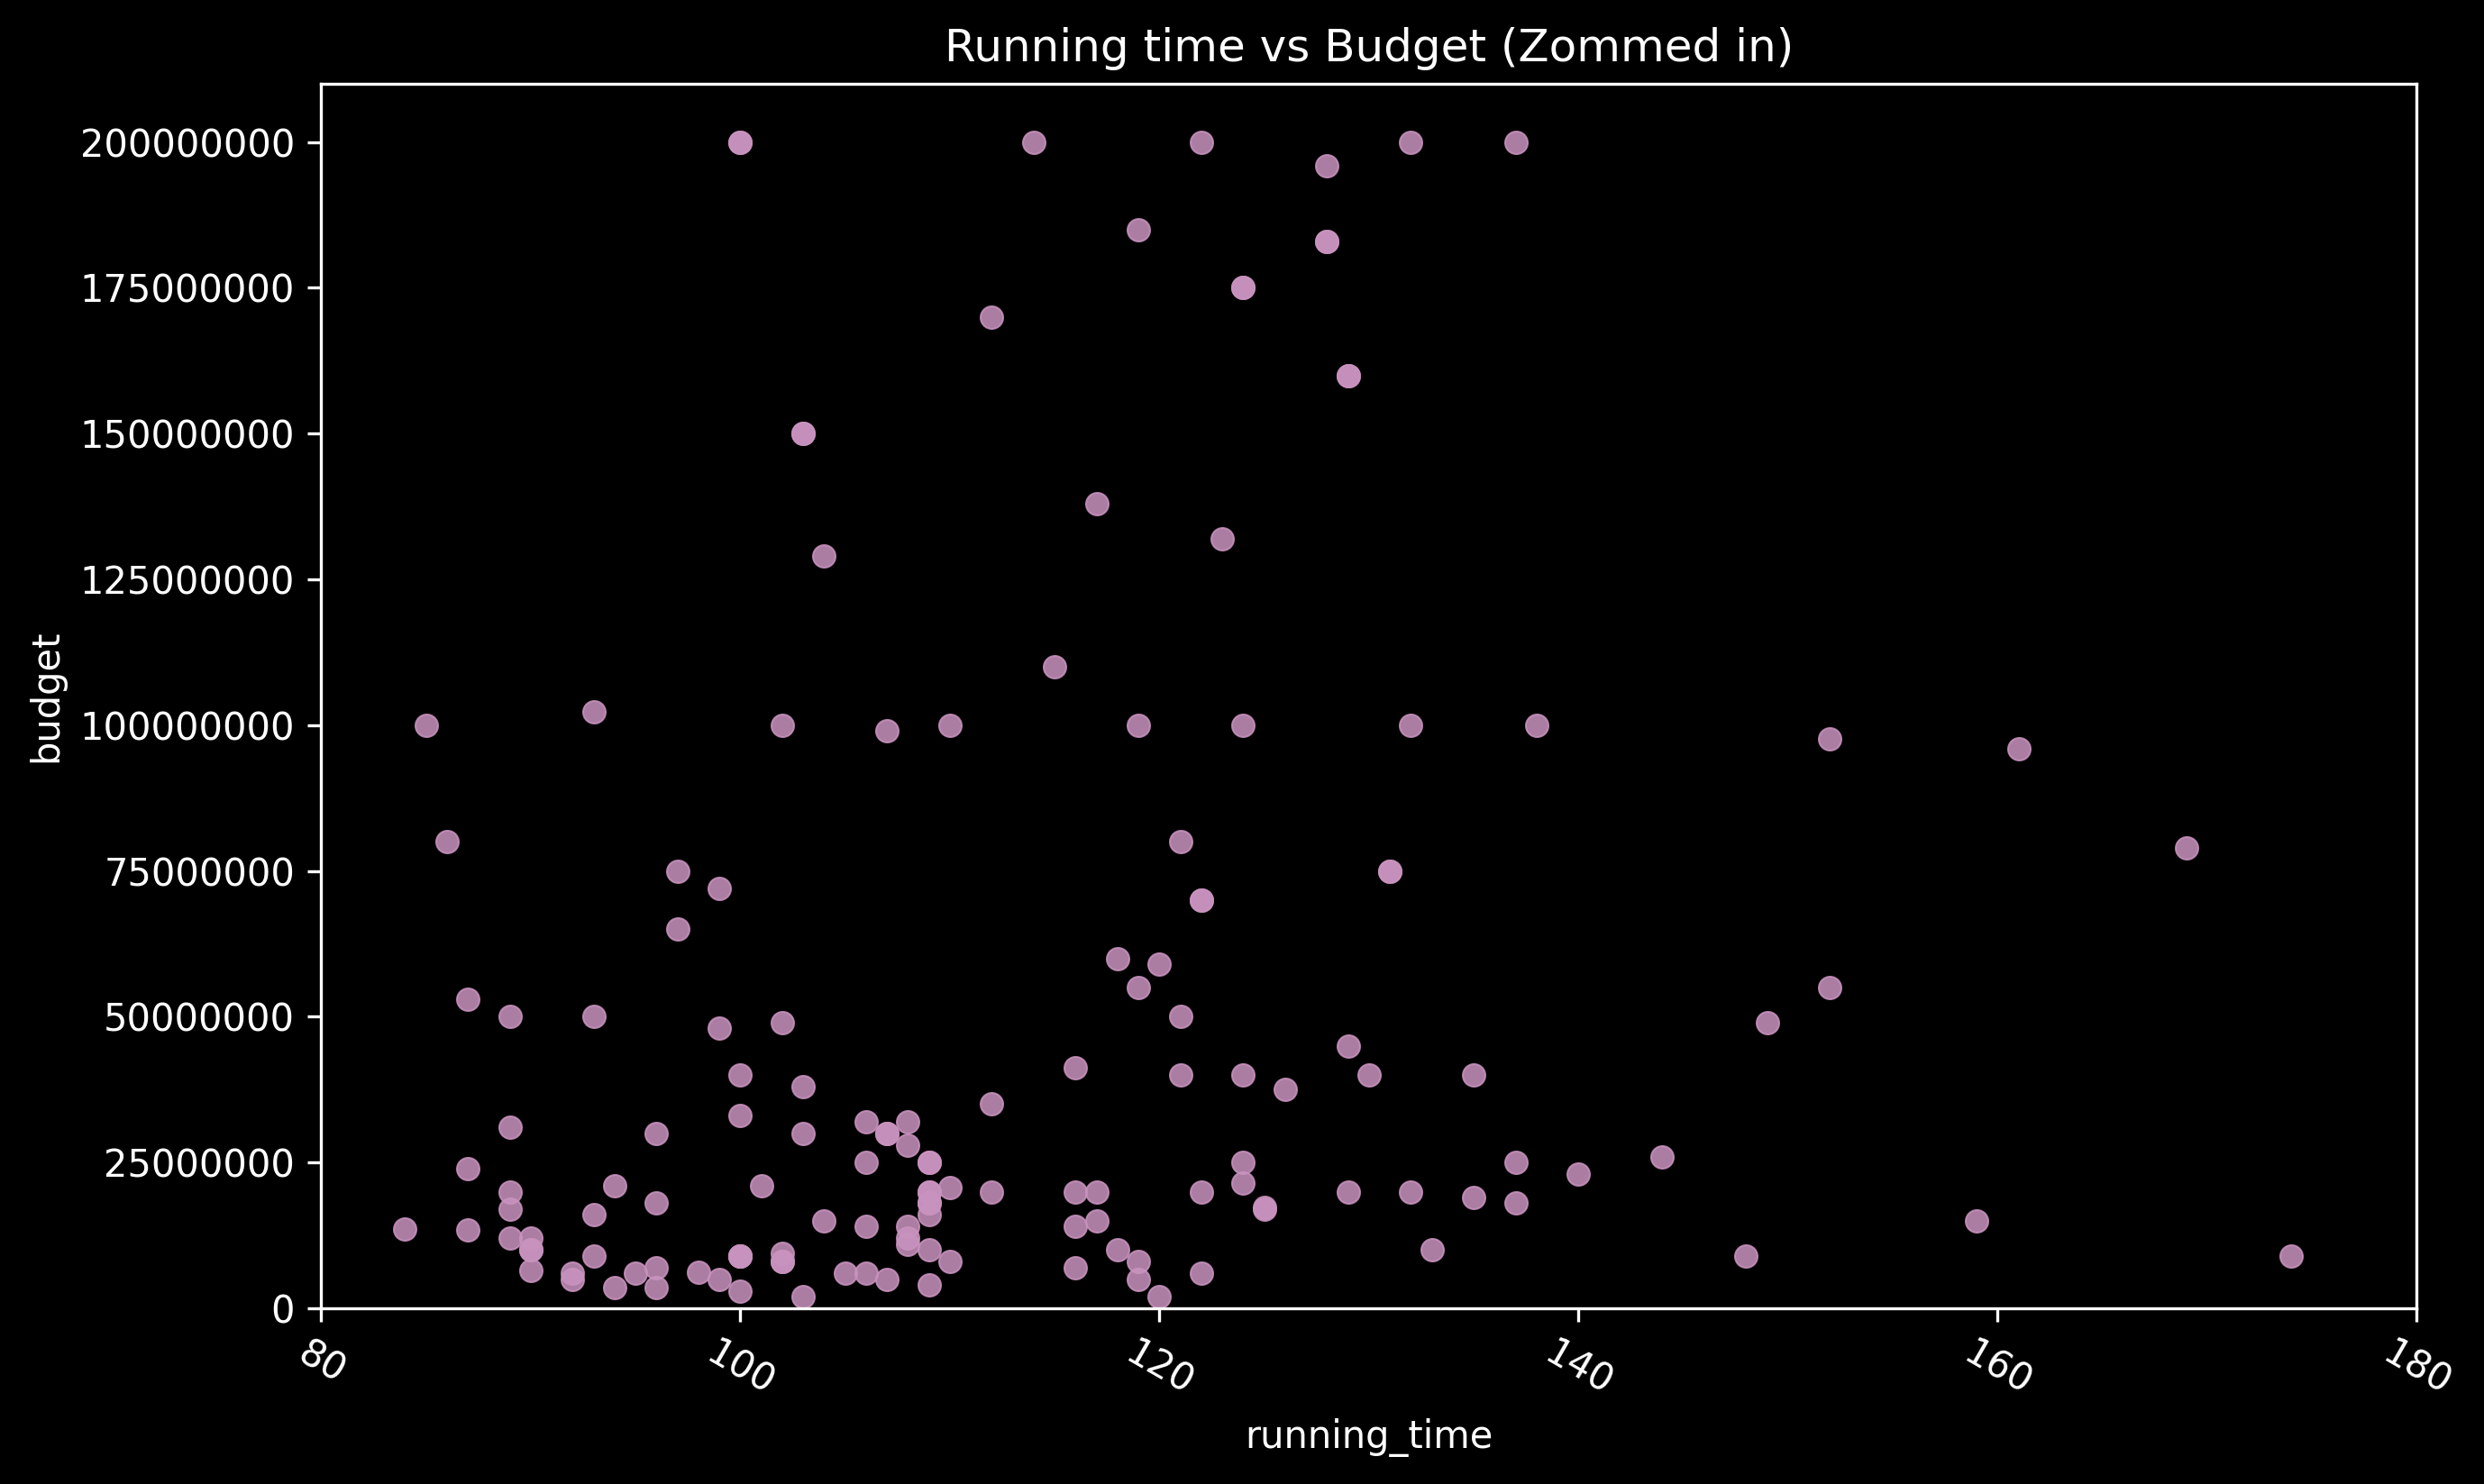

In [90]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
sns.scatterplot(x='running_time', y='budget', data=df, color='#C993BF', alpha=0.86, edgecolor='#C993BF')
plt.xticks(rotation=-30)
plt.title('Running time vs Budget (Zommed in)')
plt.xlim(80, 180)
plt.ylim(0, 210000000);

### Distributions

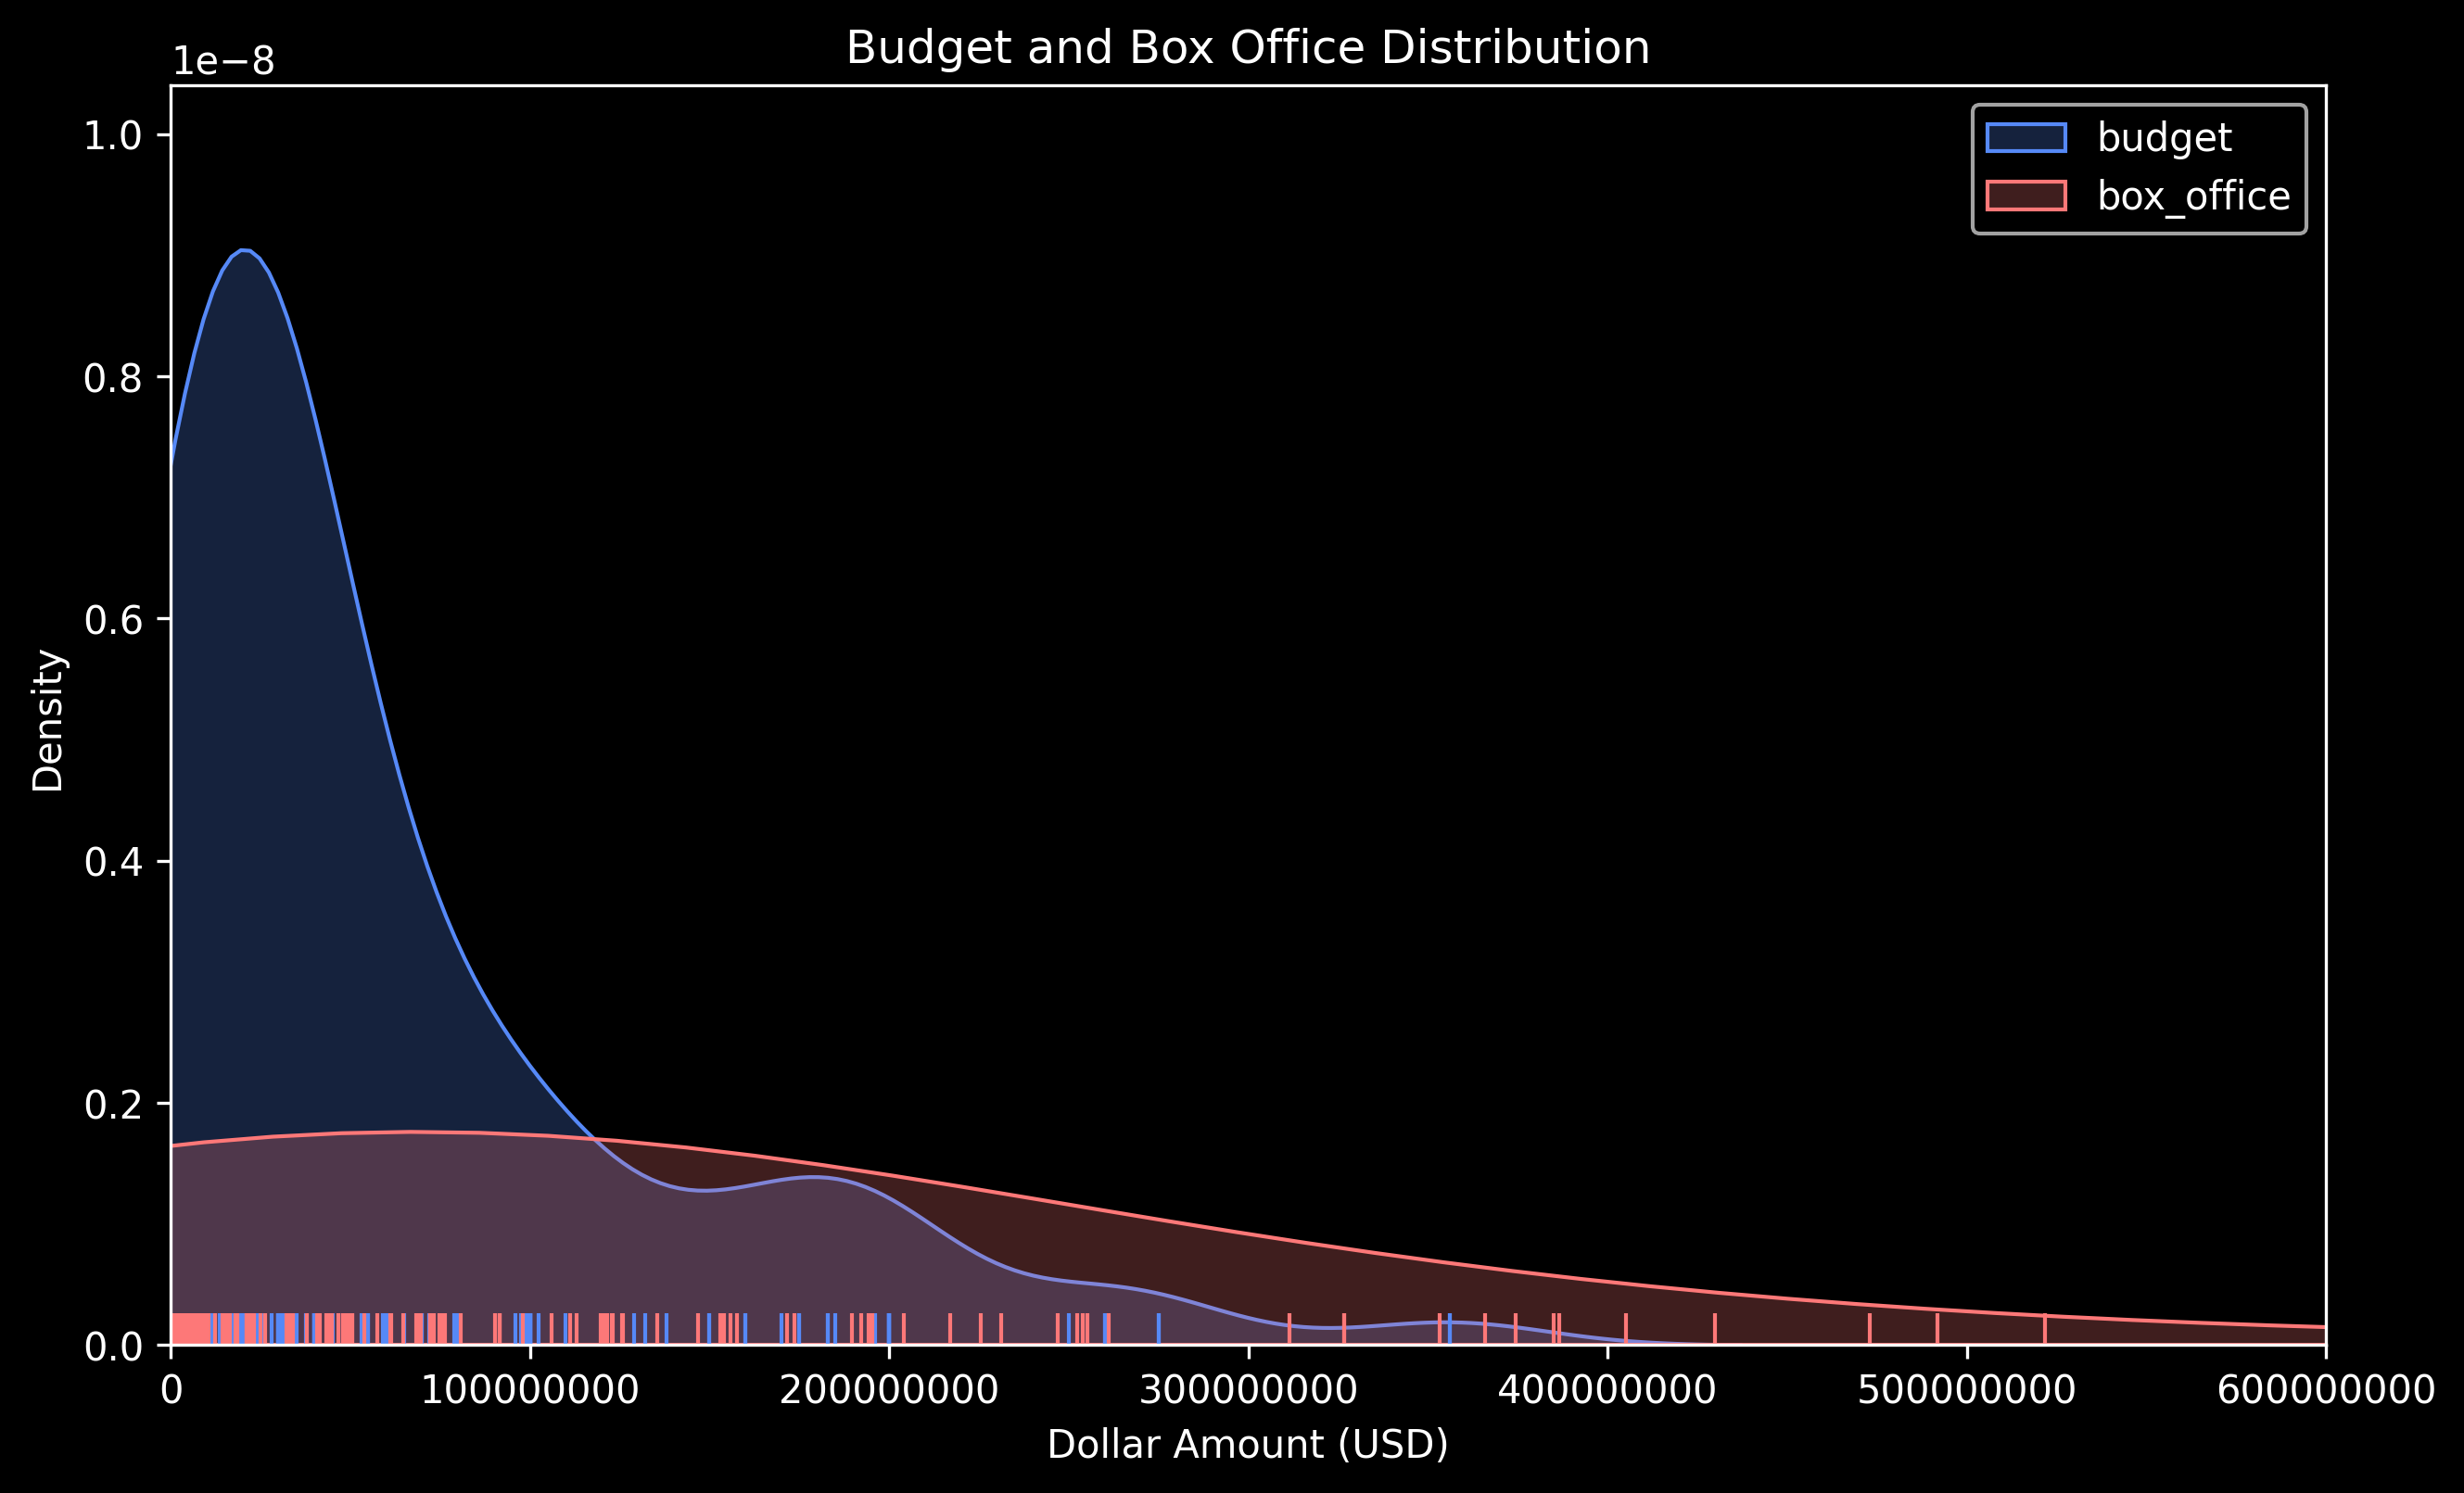

In [125]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='x')
sns.distplot(df['budget'], hist=False, kde_kws={'shade': True}, color='#5689F7', rug=True, label='budget')
sns.distplot(df['box_office'], hist=False, kde_kws={'shade': True}, color='#FD7878', rug=True, label='box_office')
plt.xlim(0, 600000000)
plt.xlabel('Dollar Amount (USD)')
plt.title('Budget and Box Office Distribution')
plt.legend();

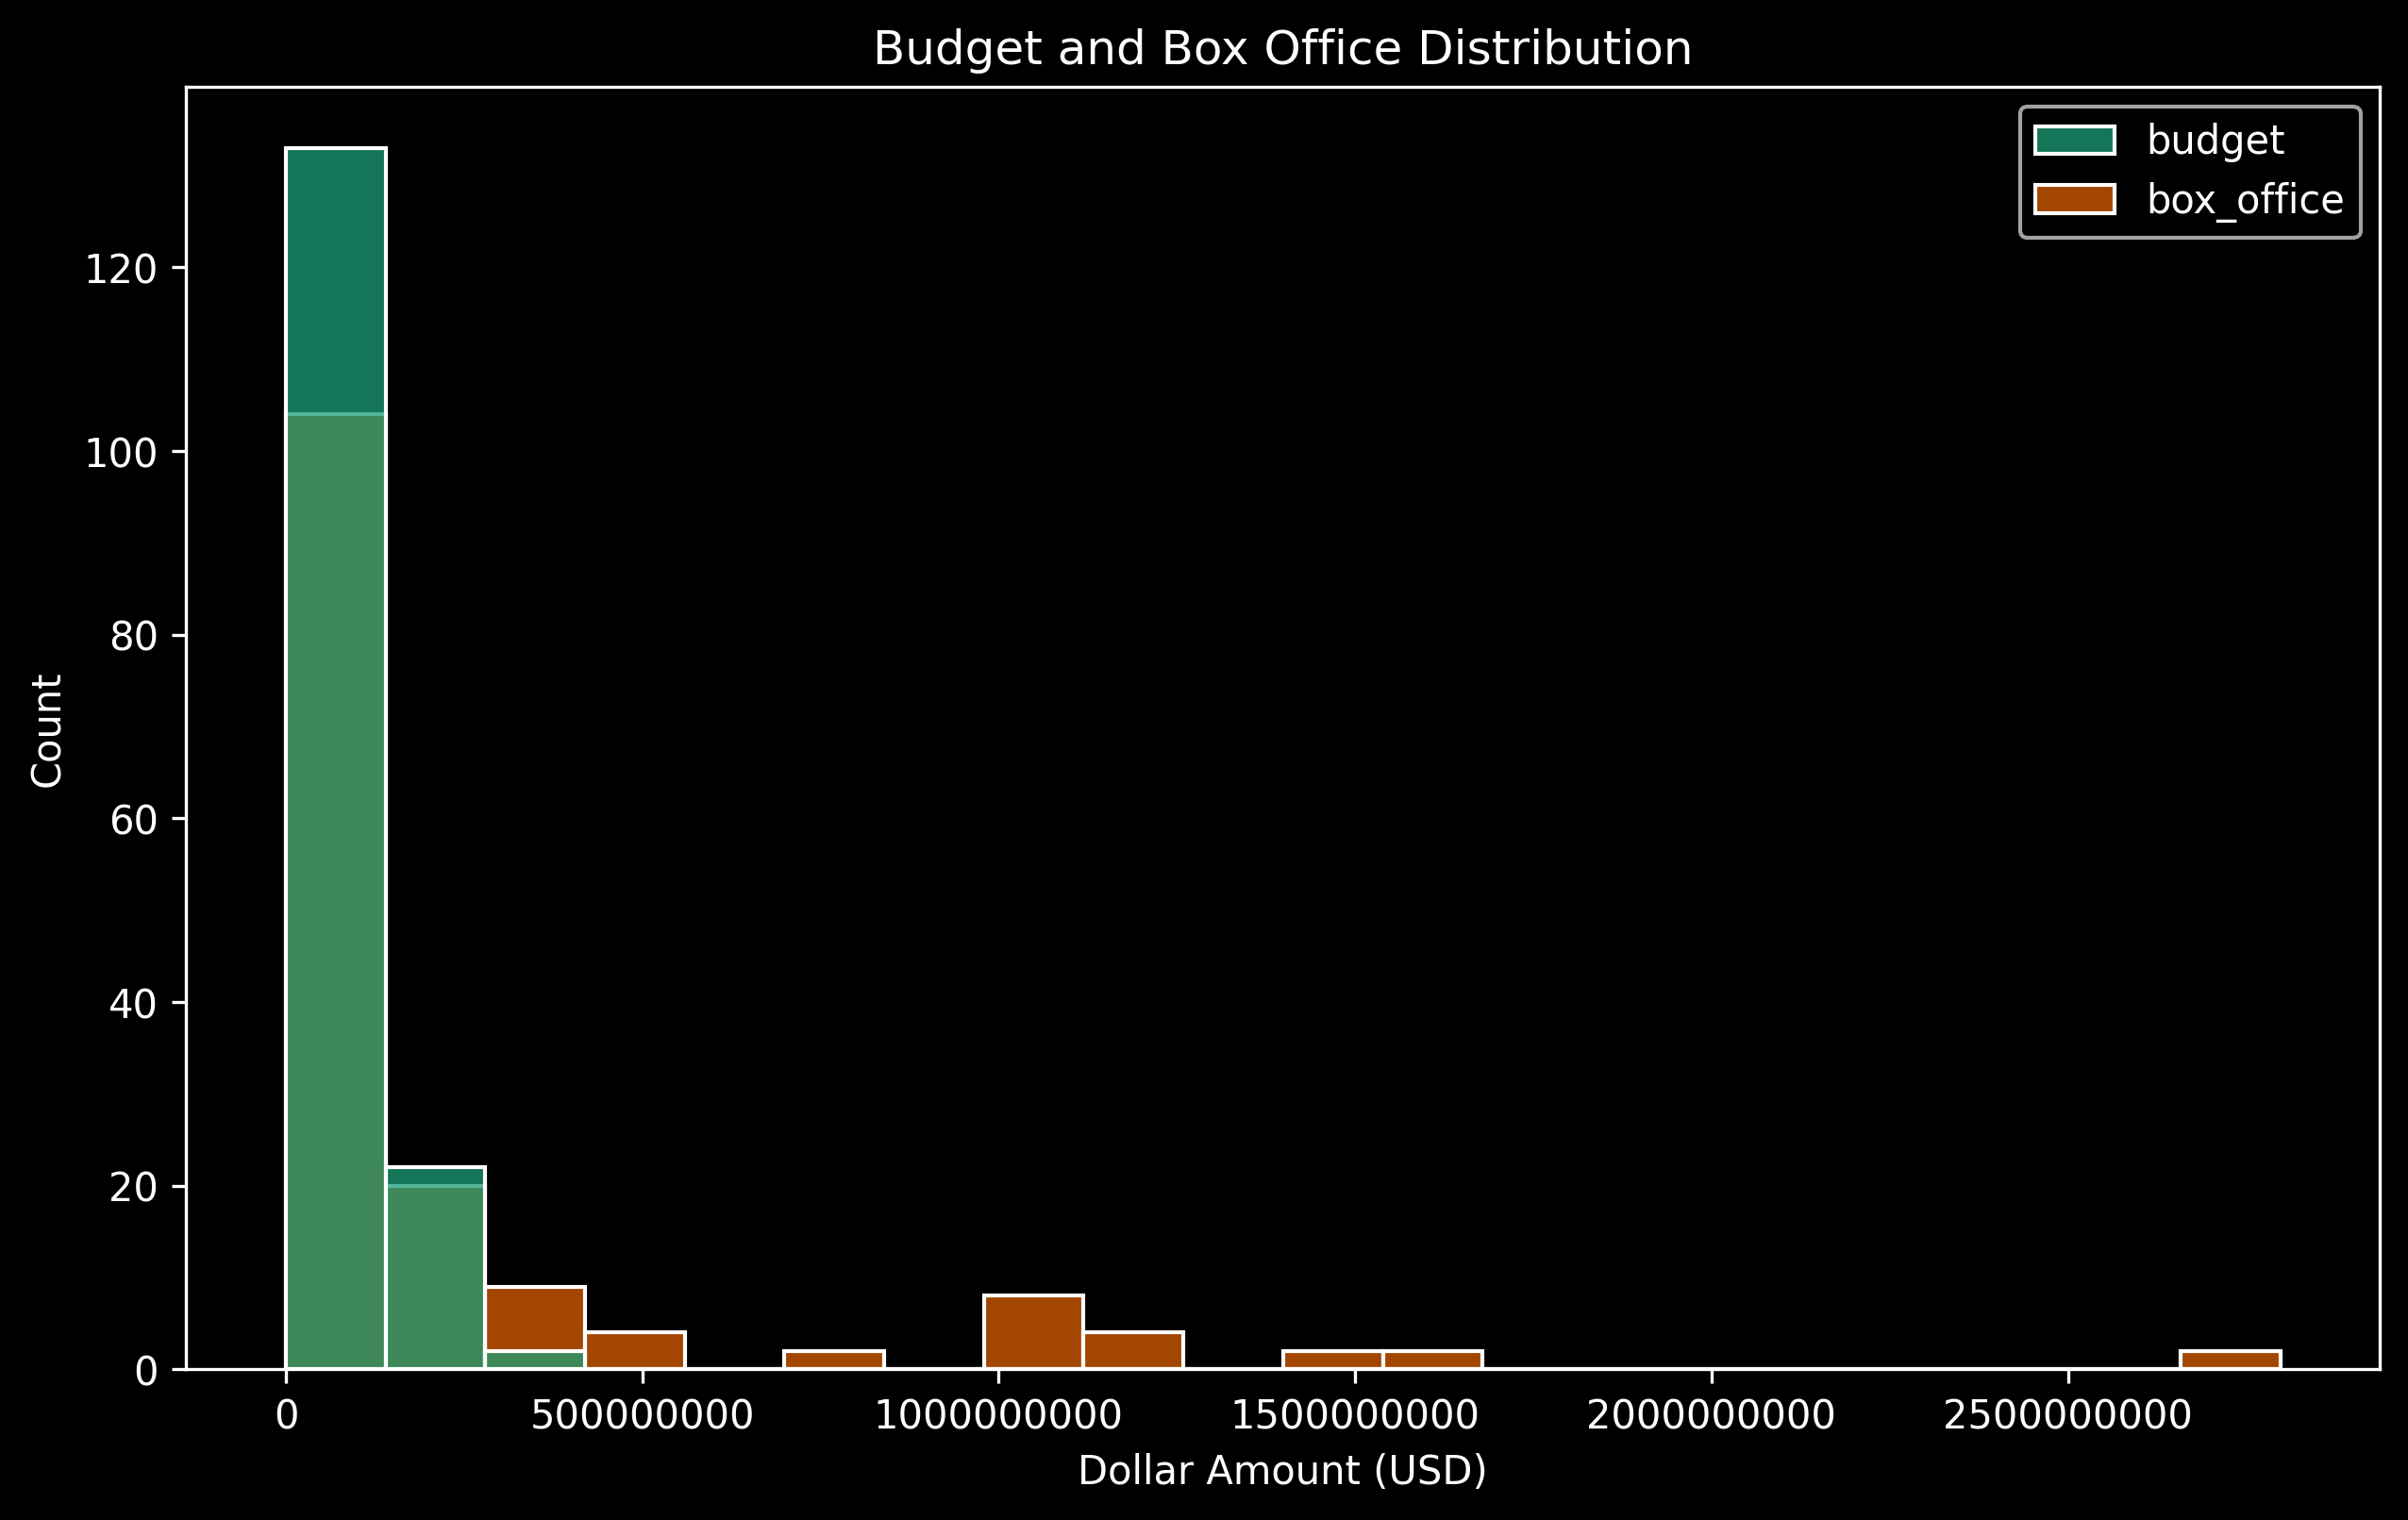

In [142]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df[['budget', 'box_office']], multiple='stack', bins=20, kde=False, palette='Dark2', legend=True, element='bars', stat='count')
plt.xlabel('Dollar Amount (USD)')
plt.title('Budget and Box Office Distribution');

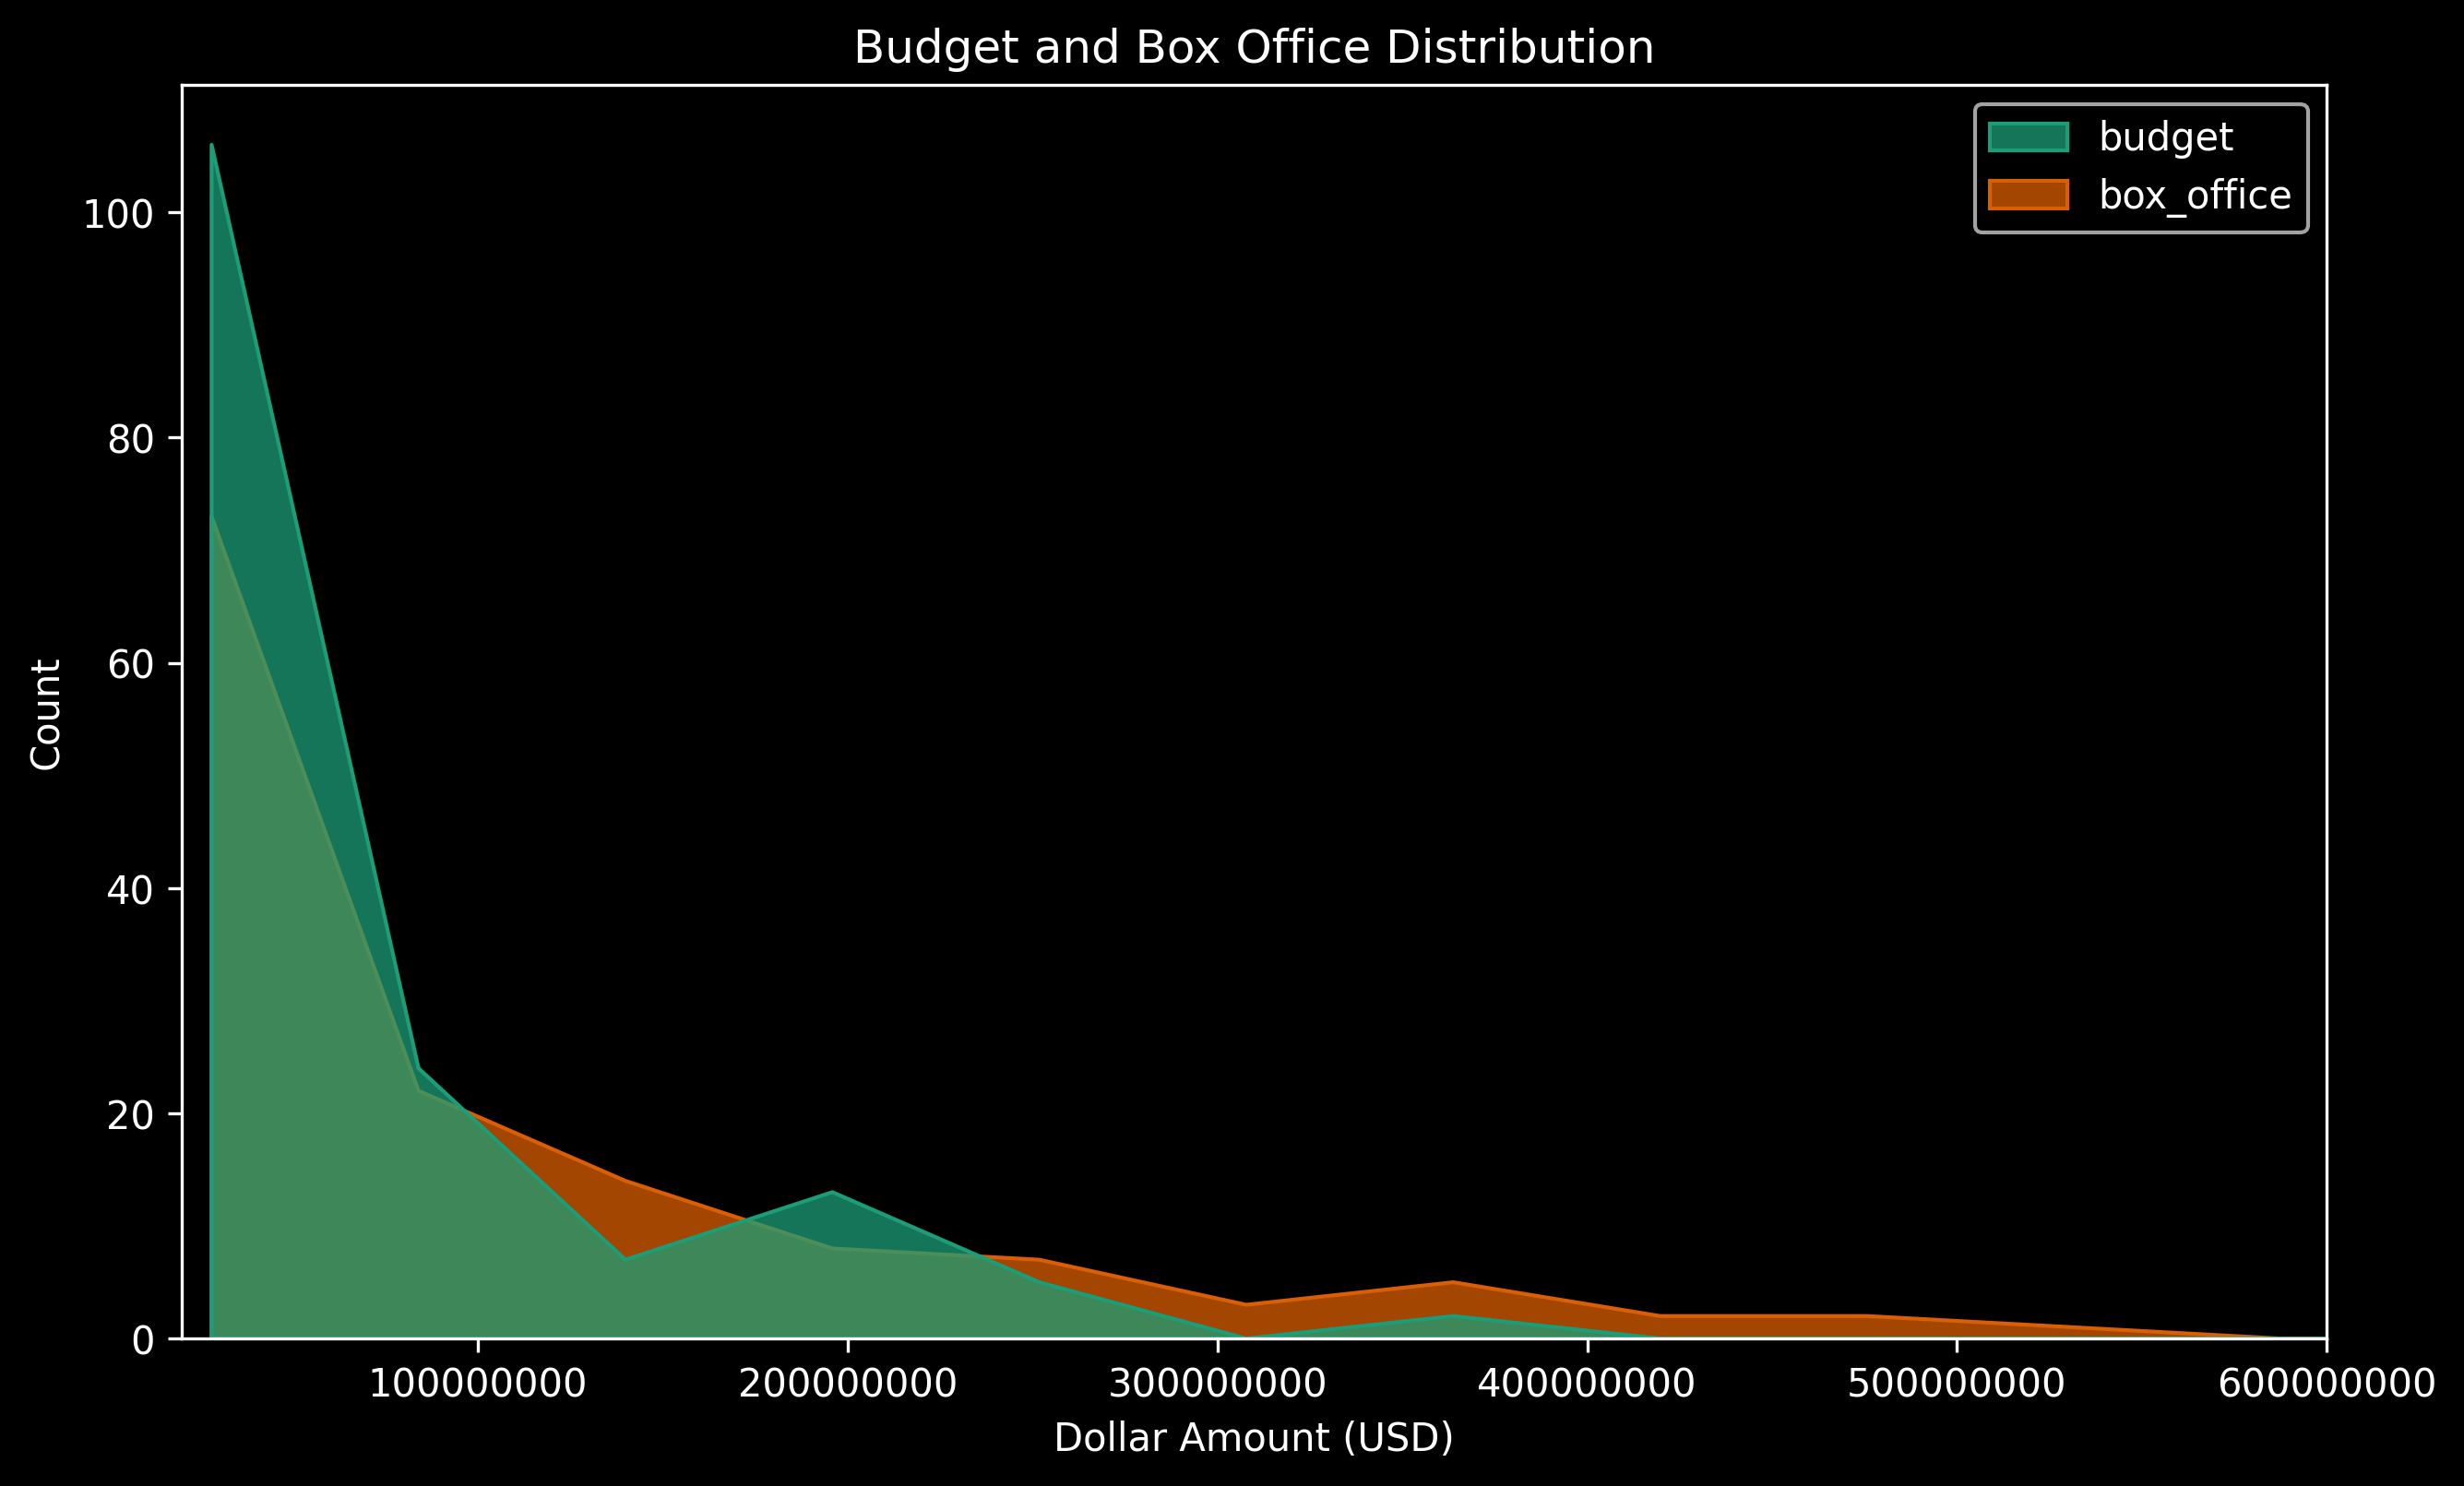

In [153]:
plt.figure(figsize=(10,6), dpi=300)
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df[['budget', 'box_office']], multiple='stack', bins=50, kde=False, palette='Dark2', legend=True, element='poly', stat='count')
plt.xlim(20000000, 600000000)
plt.xlabel('Dollar Amount (USD)')
plt.title('Budget and Box Office Distribution');

## Machine Learning

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

df['budget'] = df['budget'].fillna(lambda x: x.median())
df['box_office'] = df['box_office'].fillna(lambda x: x.median())

X = np.array(df[['budget']])
y = np.array(df['box_office'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

n_samples, n_features = X.shape

input_dim = n_features
output_dim = 1

model = LinearRegression(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1} // Loss: {loss}')

print(f'Mean Squared Error: {mean_squared_error(y_test, predicted)}')
print(f'R2 Score: {r2_score(y_test, predicted)*100:.3f}%')

Epoch: 10 // Loss: 2.3583201565868032e+17
Epoch: 20 // Loss: 1.8209721596195635e+17
Epoch: 30 // Loss: 1.4622341572277043e+17
Epoch: 40 // Loss: 1.2227378472707686e+17
Epoch: 50 // Loss: 1.0628483266484634e+17
Epoch: 60 // Loss: 9.56104817246208e+16
Epoch: 70 // Loss: 8.848419467768627e+16
Epoch: 80 // Loss: 8.37266336341033e+16
Epoch: 90 // Loss: 8.055045377910374e+16
Epoch: 100 // Loss: 7.842999406533018e+16
Mean Squared Error: 4.314356925857792e+16
R2 Score: 64.287%


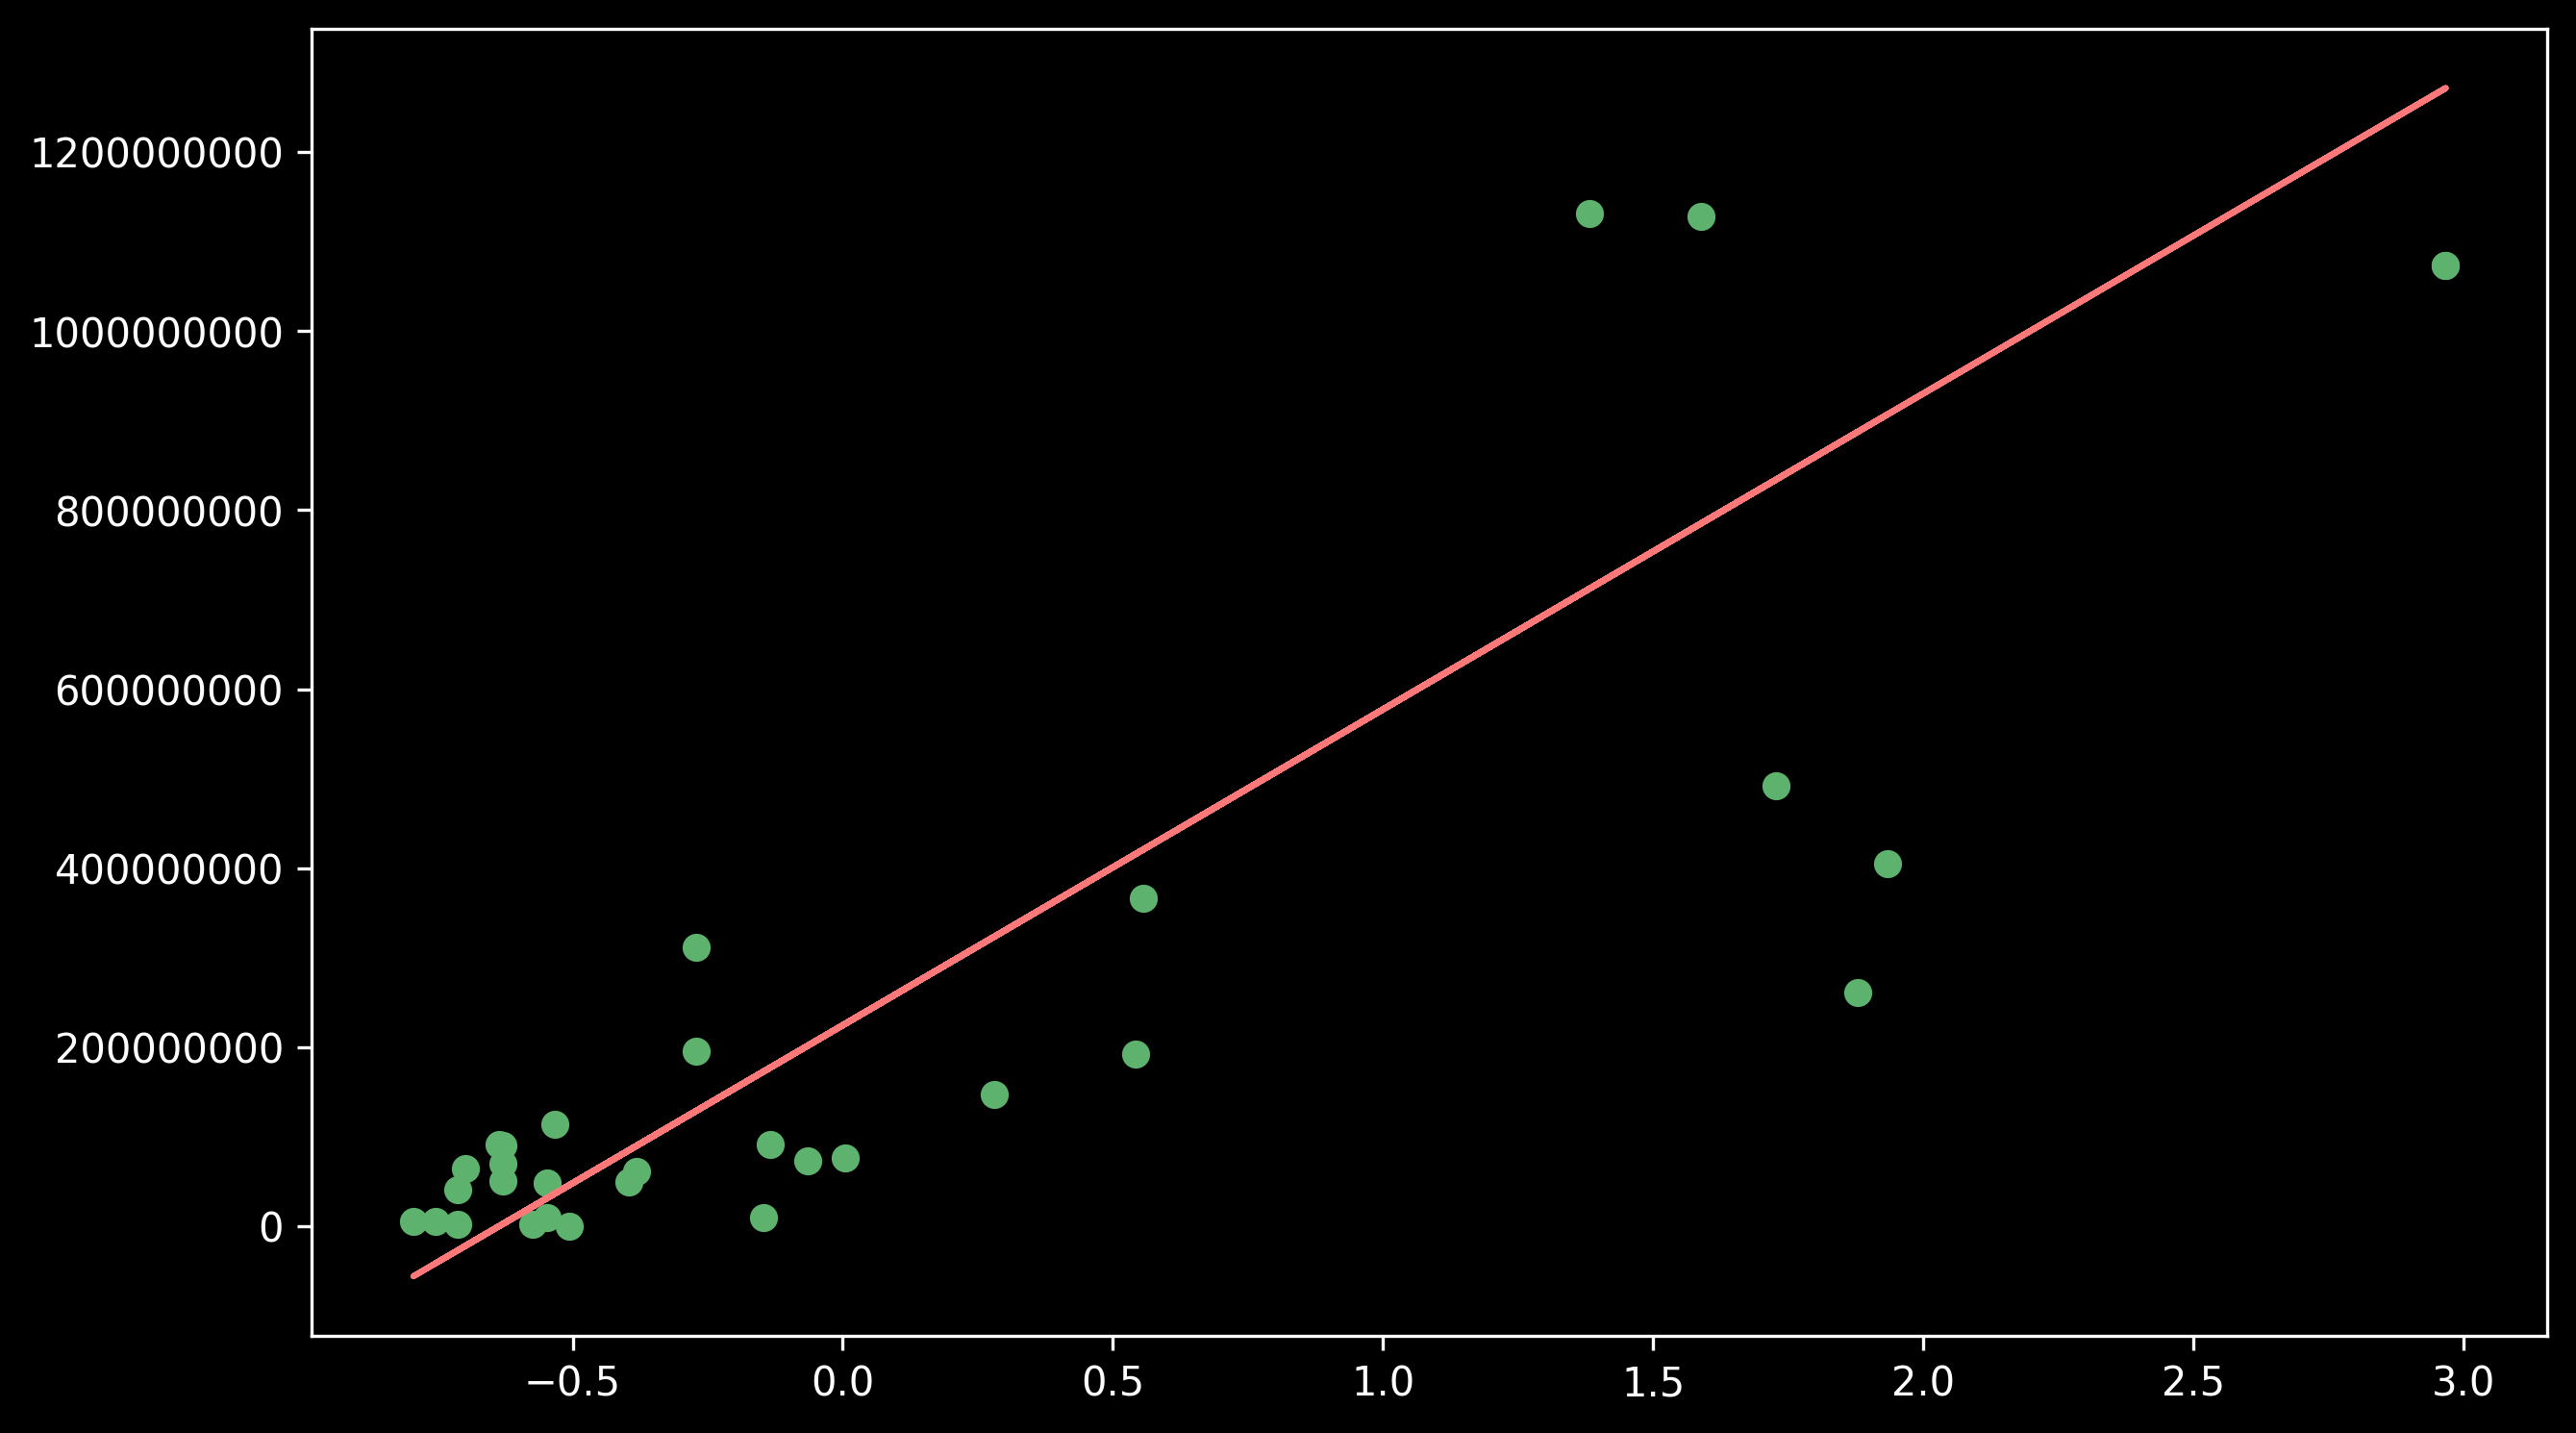

In [20]:
predicted = model(X_test).detach().numpy()
plt.figure(figsize=(10, 6), dpi=300)
plt.ticklabel_format(style='plain', axis='y')
plt.plot(X_test, y_test, 'o', color='#5DB26D')
plt.plot(X_test, predicted, color='#FD7878');


## Turning into a Classification

In [29]:
df = df[['title', 'release_date', 'running_time', 'budget', 'box_office']].copy()
df.head()

,title,release_date,running_time,budget,box_office
0,Avengers: Endgame,2019-04-26,181,356000000.0,2.798000e+09
1,The Lion King,2019-07-19,118,260000000.0,1.657000e+09
2,Star Wars: The Rise of Skywalker,2019-12-20,142,275000000.0,1.074000e+09
3,Frozen II,2019-11-22,103,150000000.0,1.450000e+09
4,Toy Story 4,2019-06-21,100,200000000.0,1.073000e+09


In [34]:
df['profit'] = 0
df.loc[df['budget'] < df['box_office'], 'profit'] = 1
df['profit'].value_counts()


1    120
0     37
Name: profit, dtype: int64

### Logistic Regression

In [56]:
from sklearn.metrics import classification_report

X, y = np.array(df[['running_time', 'budget']]), np.array(df['profit'])

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

class LogisticRegression(nn.Module):
    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = LogisticRegression(n_features)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)

num_epochs = 100
for epoch in range(num_epochs):
    # forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = y_pred.round()
    acc = y_pred_class.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy = {acc*100:.4f}%')
    print(f'\n Classification Report: {classification_report(y_test, y_pred_class)}')


epoch: 10, loss = 0.5037
epoch: 20, loss = 0.5150
epoch: 30, loss = 0.5015
epoch: 40, loss = 0.4984
epoch: 50, loss = 0.4975
epoch: 60, loss = 0.4973
epoch: 70, loss = 0.4970
epoch: 80, loss = 0.4971
epoch: 90, loss = 0.4970
epoch: 100, loss = 0.4970
accuracy = 78.1250%

 Classification Report:               precision    recall  f1-score   support

         0.0       1.00      0.12      0.22         8
         1.0       0.77      1.00      0.87        24

    accuracy                           0.78        32
   macro avg       0.89      0.56      0.55        32
weighted avg       0.83      0.78      0.71        32

